<span style="color:red">
    
## Coronavirus Vaccine willingness and uptake from Autumn 2020 to Spring 2021
</span>
    
This study aims to apply a succession of models to two waves of survey data covering UK individuals' willingness to take, and actual uptake of the COVID vaccine. 

Wave 1 of surveying took place in Autumn 2020, while Wave 2 took place in Spring 2021.

The modelling process aims to answer the following questions:
-	Can we predict willingness to take the vaccine based on some limited demographic and attitudinal information?
-	To what extent can these predictions be generalized to future data?
-	Can further information be added to the model to improve its predictions?
-	To what extent can these willingness predictions be used to predict actual uptake:
     - I.e. Do responses to the willingness questions appear to materially impact uptake predictions?

In order to obtain answers to these questions, the analysis will be conducted as follows:

- Modelling self-reported willingness to take a vaccine using Wave 1 data. The modelling will follow an iterative process, aimed at improving performance at each stage. A multiclass model will form the core of the analysis, while a binary model (constructed using the same process) will be used as a validation of the results.   
- Applying the wave 1 willingness model to wave 2 data to understand the model's generalisability over time.
- Retraining the wave 1 willingness model on wave 2, with extra features included to understand the extent to which the model is improved with the inclusion of greater explanatory information.    
- Using the final wave 2 willingness model, along with its predictions to understand the extent to which self-reported willingness is an indicator of an individual's actual uptake</span>


# Stage 2 - Wave 2 Modelling

**Summary of the Modelling process for the Wave 2 modelling**

The below notebook is divided into the following sections

- **Section 1:** Importation of Packages, data and preparation of data for modelling
- **Section 2:** Multiclass modelling on Intention data
- **Section 3**: Binary class modelling on Uptake data

**Section 1. Package & data imports and preparation for Multiclass modelling**

- Package Imports
- Data Import & Preparation
- Set target and predictor variables, and Obtain Base model accuracy score

In [1]:
# All Package imports
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from imblearn.pipeline import make_pipeline
import collections
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from scikitplot.decomposition import plot_pca_component_variance
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scikitplot.metrics import plot_roc
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

from matplotlib.colors import ListedColormap
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'

In [2]:
# Setting score accumulation Dictionary and setting multiclass model run function.

scores = {
    'Model Name': [],
    'Train Accuracy': [],
    'Cross Validation Accuracy': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test Recall': [],
    'Test F1 Score': [],
    'Cross Validation ROC AUC': [],
    'Test ROC AUC Score': [],
    'Variance': [],
    'Bias': [],
    'Variance/bias': []
}

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)

def model_run(model, xtr, xte, ytr, yte):
    """Function to run multiclass model set on train and test data, and return summary results & predictions
    (assigned to the score accumulation dictionary)
    
    :param model: Model with which to fit train data and generate test predictions
    :param xtr: Train data predictor variables
    :param xte: Test data predictor variables
    :param ytr: Train data target variable
    :param yte: Test data target variable
    :return: test data predictions"""
        
    model.fit(xtr, ytr)
    model_name = f'{model}'
    train_acc = model.score(xtr, ytr)
    meancrossval = cross_val_score(model, xtr, ytr, cv=skf).mean()
    meancrossvalroc = cross_val_score(model, xtr, ytr, scoring='roc_auc_ovr', cv=skf).mean()
    test_acc = model.score(xte, yte)
    predictions = model.predict(xte)
    
    variance = predictions.var(axis=0).mean()
    bias_sq = np.mean((yte - predictions.mean(axis=0))**2)
    variance = round(variance, 4)
    bias_sq = round(bias_sq, 4)
    
    varbias = variance + bias_sq
    
    metrics.precision_score(yte, predictions, average='weighted')
    metrics.recall_score(yte, predictions, average='weighted')
    metrics.f1_score(yte, predictions, average='weighted')
    print(f'Training accuracy score: {train_acc}')
    print(f'5-Fold Cross Val accuracy score: {meancrossval}')
    print(f'Test accuracy score: {test_acc}')
    print()
    print(f'5-Fold Cross Val ROCAUC score: {meancrossvalroc}')
    print(f"ROC_AUC_SCORE Test: {roc_auc_score(yte, model.predict_proba(xte), multi_class='ovr')}")
    print()
    print(confusion_matrix(yte, predictions))
    print()
    print(classification_report(yte, predictions))
    print()
    print()
    print(f'Variance: {variance}')
    print(f'Bias sq: {bias_sq}')
    print(f'Variance/Bias: {varbias}')
    
    scores['Model Name'].append(model_name)
    scores['Train Accuracy'].append(train_acc)
    scores['Cross Validation Accuracy'].append(meancrossval)
    scores['Test Accuracy'].append(test_acc)
    scores['Test Precision'].append(metrics.precision_score(yte, predictions, average='weighted'))
    scores['Test Recall'].append(metrics.recall_score(yte, predictions, average='weighted'))
    scores['Test F1 Score'].append(metrics.f1_score(yte, predictions, average='weighted'))
    scores['Cross Validation ROC AUC'].append(meancrossvalroc)
    scores['Test ROC AUC Score'].append(roc_auc_score(yte, model.predict_proba(xte), multi_class='ovr'))
    scores['Variance'].append(variance)
    scores['Bias'].append(bias_sq)
    scores['Variance/bias'].append(varbias)
    
    return predictions

In [3]:
# Setting binary class model run function.

skf = StratifiedKFold(n_splits=5)

def model_run_binary(model, xtr, xte, ytr, yte):
    """Function to run binary class model set on train and test data, and return summary results & predictions
    (assigned to the score accumulation dictionary)
    
    :param model: Model with which to fit train data and generate test predictions
    :param xtr: Train data predictor variables
    :param xte: Test data predictor variables
    :param ytr: Train data target variable
    :param yte: Test data target variable
    :return: test data predictions"""
        
    model.fit(xtr, ytr)
    model_name = f'{model}'
    train_acc = model.score(xtr, ytr)
    meancrossval = cross_val_score(model, xtr, ytr, cv=skf).mean()
    meancrossvalroc = cross_val_score(model, xtr, ytr, scoring='roc_auc', cv=skf).mean()
    test_acc = model.score(xte, yte)
    predictions = model.predict(xte)
    
    variance = predictions.var(axis=0).mean()
    bias_sq = np.mean((yte - predictions.mean(axis=0))**2)
    variance = round(variance, 4)
    bias_sq = round(bias_sq, 4)
    
    varbias = variance + bias_sq
    
    metrics.precision_score(yte, predictions, average='weighted')
    metrics.recall_score(yte, predictions, average='weighted')
    metrics.f1_score(yte, predictions, average='weighted')
    print(f'Training accuracy score: {train_acc}')
    print(f'5-Fold Cross Val accuracy score: {meancrossval}')
    print(f'Test accuracy score: {test_acc}')
    print()
    print(f'5-Fold Cross Val ROCAUC score: {meancrossvalroc}')
    print(f"ROC_AUC_SCORE Test: {roc_auc_score(yte, model.predict_proba(xte)[:,1])}")
    print()
    print(confusion_matrix(yte, predictions))
    print()
    print(classification_report(yte, predictions))
    scores['Model Name'].append(model_name)
    scores['Train Accuracy'].append(train_acc)
    scores['Cross Validation Accuracy'].append(meancrossval)
    scores['Test Accuracy'].append(test_acc)
    scores['Test Precision'].append(metrics.precision_score(yte, predictions, average='weighted'))
    scores['Test Recall'].append(metrics.recall_score(yte, predictions, average='weighted'))
    scores['Test F1 Score'].append(metrics.f1_score(yte, predictions, average='weighted'))
    scores['Cross Validation ROC AUC'].append(meancrossvalroc)
    scores['Test ROC AUC Score'].append(roc_auc_score(yte, model.predict_proba(xte)[:,1]))
    scores['Variance'].append(variance)
    scores['Bias'].append(bias_sq)
    scores['Variance/bias'].append(varbias)
    
    return predictions

In [4]:
# Data Import
w2_intention = pd.read_csv("C:/Users/laure/OneDrive/Documents/Personal Admin Files/Stats or Career Stuff/General Assembly/Course Notes/Capstone Folder/Cleaned_data/wave_2_vaccine_intention_data_dropped.csv")
w2_intention.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
w2_intention.shape

(2500, 108)

**Section 2 - Multiclass Intention**

 <span style="color:red"> **Section 2a - Model consistent with Wave 1 spec, but refit on Wave 2 data**

i.e. The model is a multiclass model, using consistent parameters with the optimised wave 1 logistic regression, on SMOTE oversampled data, with PCA applied to the emotion and knowledge variables.


In [6]:
# Setting target variable
y = w2_intention['intention']

In [7]:
# Obtaining Base model accuracy prediction
y.value_counts(normalize=True).max()

0.7092

In [8]:
# Creating predictor variables

X = w2_intention[['DEMAGE', 'VAC_DEC',  'COV_KNOWL_1', 'COV_KNOWL_2',
     'COV_KNOWL_3', 'COV_KNOWL_4', 'COV_KNOWL_5', 'COV_KNOWL_6',
     'COV_KNOWL_7', 'DREAD', 'ANX_1', 'ANX_2', 'ANX_3', 'ANX_4', 'ANX_5',
     'ANX_6', 'DEMREG_East of England',
     'DEMREG_Greater London', 'DEMREG_North East', 'DEMREG_North West',
     'DEMREG_Northern Ireland', 'DEMREG_Scotland', 'DEMREG_South East',
     'DEMREG_South West', 'DEMREG_Wales', 'DEMREG_West Midlands',
     'DEMREG_Yorkshire and The Humber', 'DEMSEX_Male',
     'DEMEDU_2+ A levels or equivalents',
     'DEMEDU_5+ GCSE, O-levels, 1 A level, or equivalents',
     'DEMEDU_Apprenticeship', 'DEMEDU_No academic qualifications',
     'DEMEDU_Other',
     'DEMEDU_Undergraduate or postgraduate degree',
     'DEMWRK_Retired', 'DEMWRK_Student',
     'DEMWRK_Unable to work',
     'DEMWRK_Unemployed',
     'DEMWRK_Working full-time',
     'DEMWRK_Working part-time',
     'DEMREL_Christian', 'DEMREL_Muslim', 'DEMREL_Other',
     'DEMINC_Under £15,000', 'DEMINC_£15,000 to £24,999',
     'DEMINC_£25,000 to £34,999', 'DEMINC_£35,000 to £44,999',
     'DEMINC_£45,000 to £54,999', 'DEMINC_£55,000 to £64,999',
     'DEMINC_£65,000 to £99,999', 'COV_SHIELD_Yes',
     'COV_TRUST_1_National television',
     'COV_TRUST_2_Satellite / international television channels',
     'COV_TRUST_3_Radio', 'COV_TRUST_4_Newspapers',
     'COV_TRUST_5_Social media (Facebook, Twitter, etc)',
     'COV_TRUST_6_National public health authorities (such as the NHS or Public Health England / Wales)',
     'COV_TRUST_7_Healthcare workers',
     'COV_TRUST_8_International health authorities (such as The World Health Organization)',
     'COV_TRUST_9_Government websites',
     'COV_TRUST_10_The internet or search engines',
     'COV_TRUST_11_Family and friends',
     'COV_TRUST_12_Work, school, or college',
     'COV_TRUST_13_Other (please specify)']]

In [9]:
# Running data preprocessing as per wave 1 setup (train/test split, standard scaling, PCA and SMOTE oversampling)
#Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=3)

# Standardisation of train and test data
scaler = StandardScaler()
Xstd_train = scaler.fit_transform(X_train)
Xstd_test = scaler.transform(X_test)

# Applying PCA to emotion vars
emotion_vars = ['DREAD', 'ANX_1', 'ANX_2', 'ANX_3', 'ANX_4', 'ANX_5',
     'ANX_6']

# Creating train test data frames on which to apply the PCA.
X_traindf = pd.DataFrame(Xstd_train, columns=list(X.columns))
X_testdf = pd.DataFrame(Xstd_test, columns=list(X.columns))
# Fitting PCA on train data, and adding to train data frame.
pca_emomulti = PCA(n_components=3)
pca_emomulti.fit(X_traindf[emotion_vars])

# Transforming variables and adding to train/test data frames.
emo_tran_train = pd.DataFrame(pca_emomulti.transform(X_traindf[emotion_vars]),
                             columns=[f'PCemo_{i+1}' for i in range(pca_emomulti.n_components_)])
emo_tran_test = pd.DataFrame(pca_emomulti.transform(X_testdf[emotion_vars]),
                             columns=[f'PCemo_{i+1}' for i in range(pca_emomulti.n_components_)])

# Merging the PCA variables to the original train and test data for use in regression, then dropping original variables.
merged_train = pd.merge(X_traindf, emo_tran_train, left_index=True, right_index=True)
merged_train.drop(emotion_vars, axis=1, inplace=True)
merged_test = pd.merge(X_testdf, emo_tran_test, left_index=True, right_index=True)
merged_test.drop(emotion_vars, axis=1, inplace=True)

# Applying PCA to knowledge vars
knowledge_vars = ['COV_KNOWL_1', 'COV_KNOWL_2',
     'COV_KNOWL_3', 'COV_KNOWL_4', 'COV_KNOWL_5', 'COV_KNOWL_6',
     'COV_KNOWL_7']

# Fitting PCA on train data, and adding to train data frame.
pca_knomulti = PCA(n_components=3)
pca_knomulti.fit(merged_train[knowledge_vars])

# Transforming variables and adding to train/test data frames.
know_tran_train = pd.DataFrame(pca_knomulti.transform(merged_train[knowledge_vars]),
                             columns=[f'PCknow_{i+1}' for i in range(pca_knomulti.n_components_)])
know_tran_test = pd.DataFrame(pca_knomulti.transform(merged_test[knowledge_vars]),
                             columns=[f'PCknow_{i+1}' for i in range(pca_knomulti.n_components_)])

# Merging the PCA variables to the original train and test data for use in regression, then dropping original variables.
Xtr_final = pd.merge(merged_train, know_tran_train, left_index=True, right_index=True)
Xtr_final.drop(knowledge_vars, axis=1, inplace=True)
Xte_final = pd.merge(merged_test, know_tran_test, left_index=True, right_index=True)
Xte_final.drop(knowledge_vars, axis=1, inplace=True)

# Applying SMOTE oversampling to training data - test data is to remain unbalanced.
over = SMOTE()
X_smote, y_smote = over.fit_resample(Xtr_final, y_train)

In [10]:
# Initialising score dictionary and fitting Wave 1 spec model
scores = {
    'Model Name': [],
    'Train Accuracy': [],
    'Cross Validation Accuracy': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test Recall': [],
    'Test F1 Score': [],
    'Cross Validation ROC AUC': [],
    'Test ROC AUC Score': [],
    'Variance': [],
    'Bias': [],
    'Variance/bias': []
}

w1spec = LogisticRegression(C=0.001, l1_ratio=0.1, max_iter=1000, multi_class='ovr',
                   penalty='elasticnet', solver='saga')

models = [w1spec]

for model in models:
    print(f'Model: {model}')
    model_run(model, X_smote, Xte_final, y_smote, y_test)
    print()
    print('-----------------------')
    print()

Model: LogisticRegression(C=0.001, l1_ratio=0.1, max_iter=1000, multi_class='ovr',
                   penalty='elasticnet', solver='saga')
Training accuracy score: 0.4781382228490832
5-Fold Cross Val accuracy score: 0.45151450170539736
Test accuracy score: 0.56

5-Fold Cross Val ROCAUC score: 0.7427136325257847
ROC_AUC_SCORE Test: 0.6106034499944489

[[242  64  16  33]
 [ 40  20   7  13]
 [ 19   3   4  10]
 [ 13   2   0  14]]

              precision    recall  f1-score   support

         1.0       0.77      0.68      0.72       355
         2.0       0.22      0.25      0.24        80
         3.0       0.15      0.11      0.13        36
         4.0       0.20      0.48      0.28        29

    accuracy                           0.56       500
   macro avg       0.34      0.38      0.34       500
weighted avg       0.61      0.56      0.58       500



Variance: 1.1556
Bias sq: 0.7935
Variance/Bias: 1.9491

-----------------------



**Results Analysis**

When retrained on the wave 2 data, the model performs broadly consistently with the original model (trained on wave 1 data only). We see some marginal improvements in the model's performance on wave 2 data - there is an increase in class 4 and class 2 recall, and the class 2 ROC no longer performs worse than a 'random' prediction, but nevertheless the model does not perform well. As before, classes 1 and 4 tend to be predicted relatively well compared to classes 2 and 3 (to be expected given they lay on the 'extreme' of the willingness scale).

This finding suggests either that the reduced wave 2 intention base size is not sufficient to train an effective model, or that the modelling parameters and features used to fit the wave 1 model no longer adequately explain patterns in willingness to take the vaccine in wave 2. 

Indeed, looking into the feature coefficients, we see some variation on the findings found in the previous wave. High Knowledge scale 1 scores (i.e. demonstrating a **lack** of agreement with a series of knowledge statements) remains an indicator of reduced willingness to take the COVID vaccine, while the impact of Age now flips, and becomes a driver of reduced willigness - the opposite was observed in wave 1. This may be due to the changed nature of the sample highlighted in the EDA - those of older age groups remaining in the willingness sample are likely to be those who are 'holding out', and therefore this group are disproportionately skeptical of vaccine uptake. 

Whereas in wave 1 men were more likely to express willingness to take the vaccine, this effect seems to have disappeared this wave, as predicted by the EDA. This is likely due to previous fears about safety risks to women posed by the vaccine were assuaged by increased information, a succesful rollout, and new vaccine types becoming available. Income remains an indicator of COVID skepticism, with lower incomes indicating higher skepticism, and higher incomes indicating higher willingness.

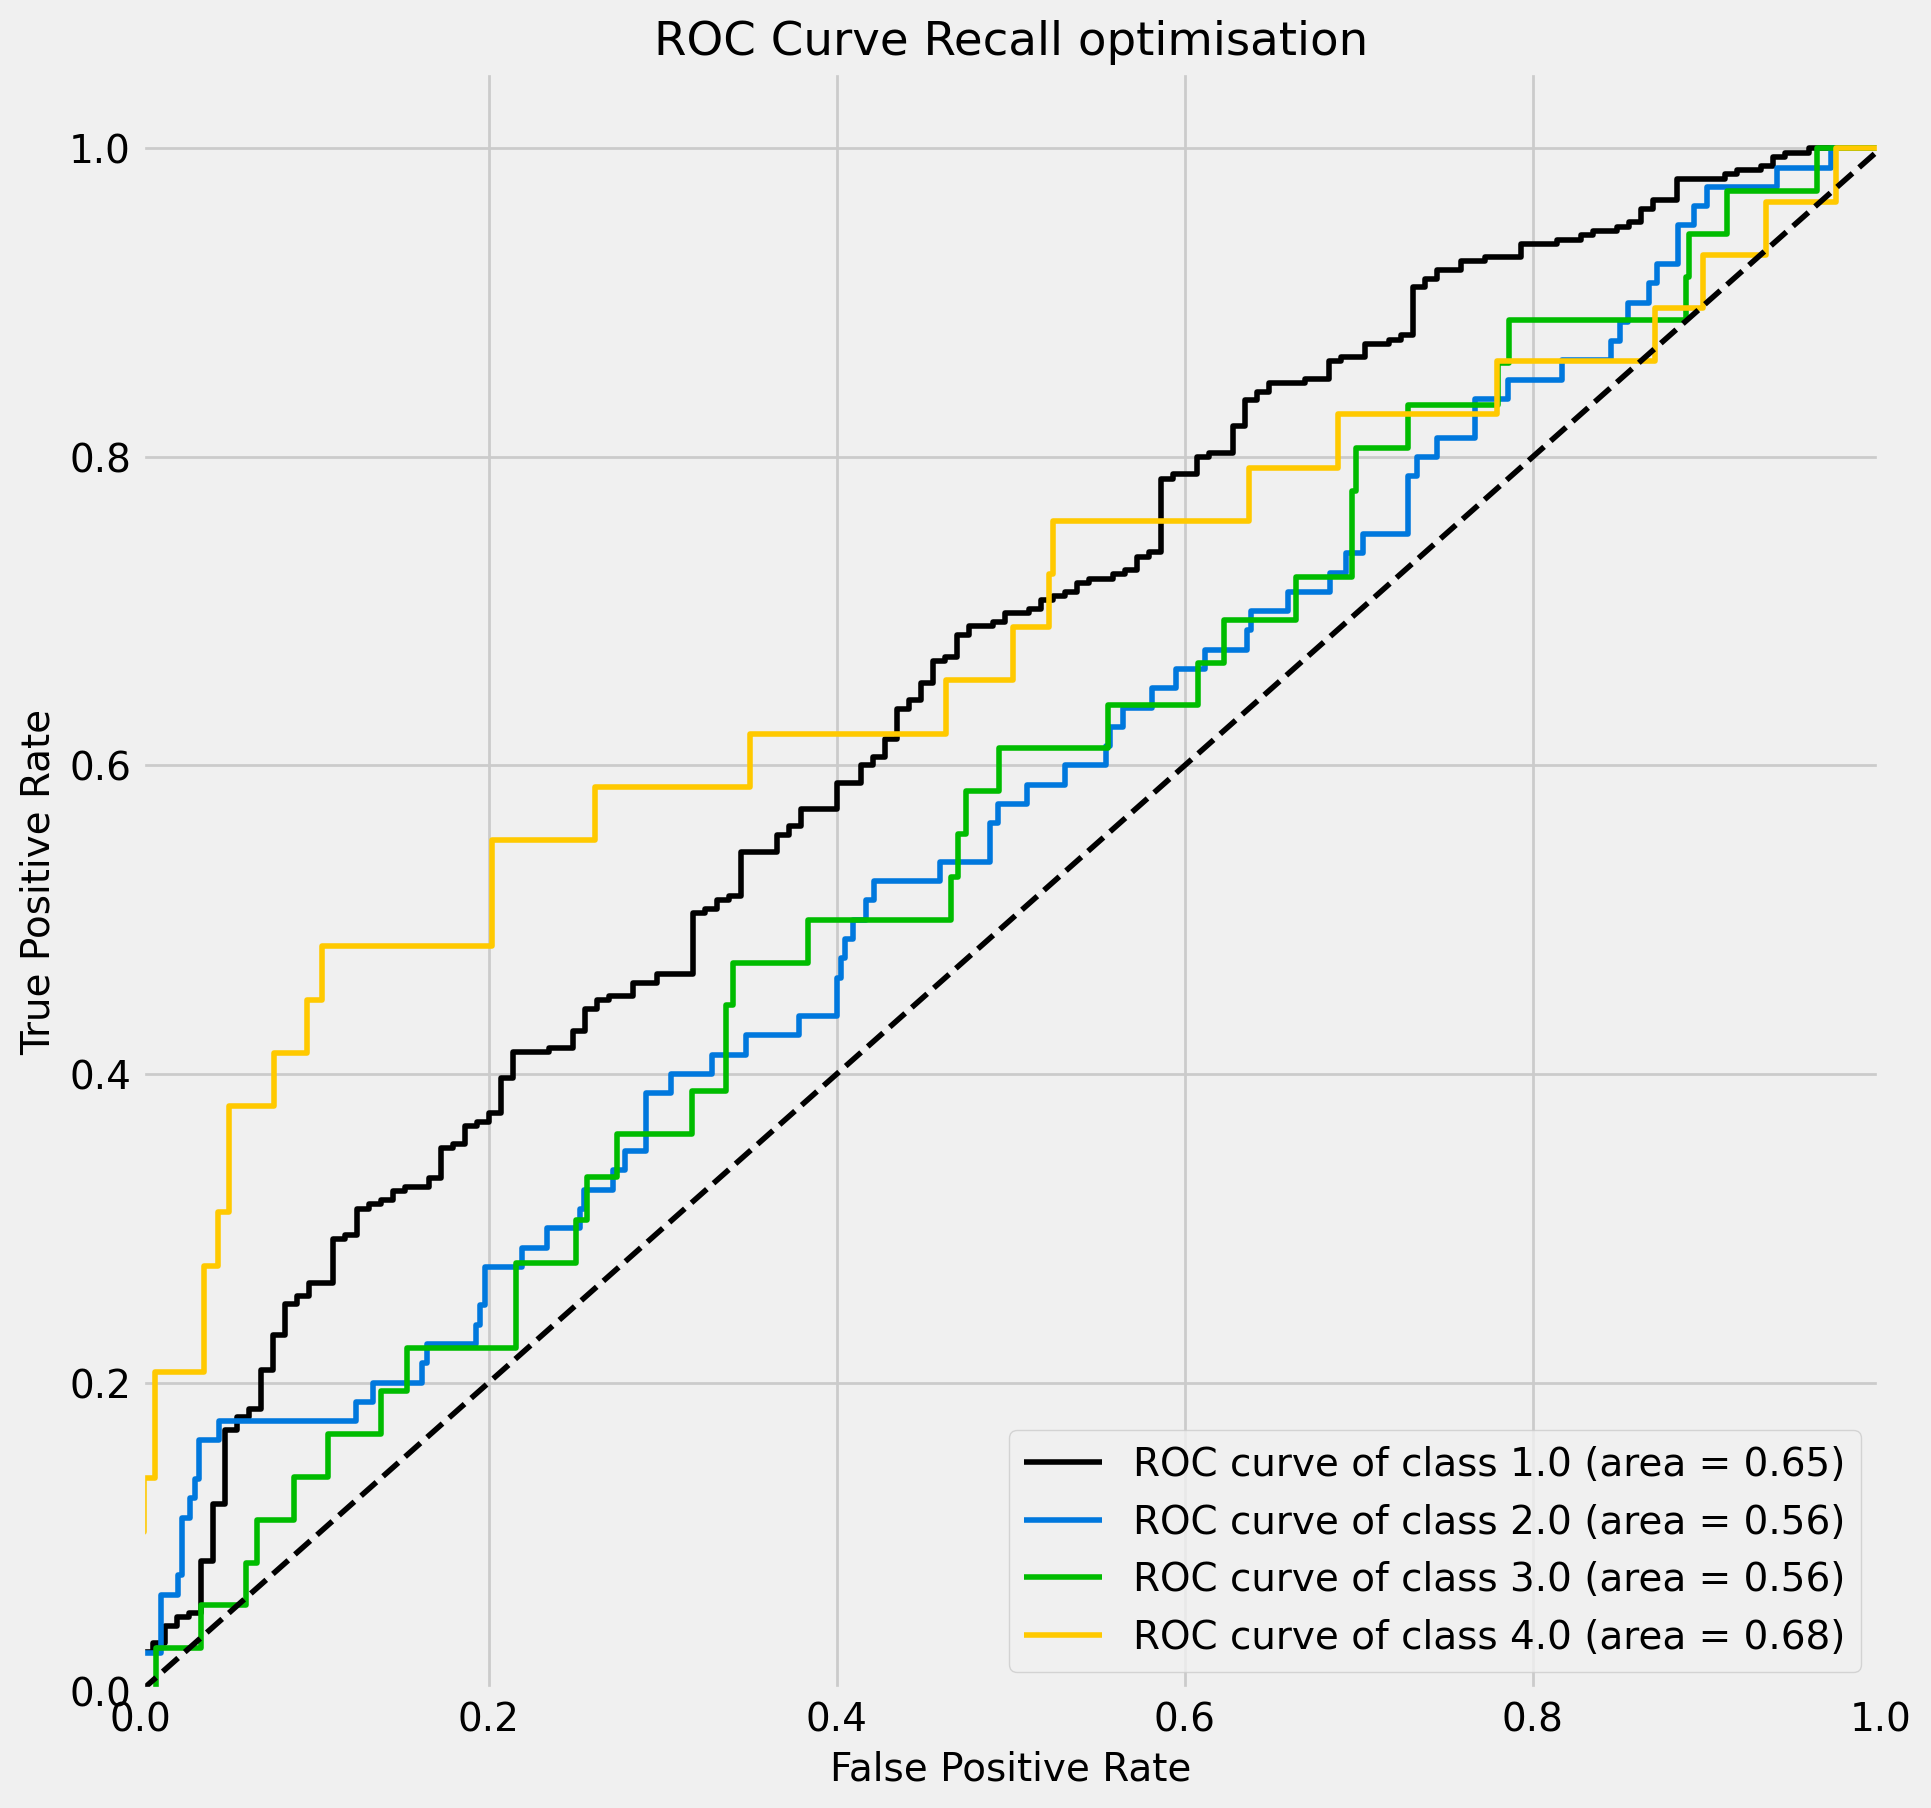

In [11]:
probas = w1spec.predict_proba(Xte_final)
plot_roc(y_test, probas, title='ROC Curve Recall optimisation', plot_micro=False, plot_macro=False, figsize=(10, 10))
plt.show()

In [12]:
# Generating Coefficients

value_1 = list(np.exp(w1spec.coef_[0]))
value_2 = list(np.exp(w1spec.coef_[1]))
value_3 = list(np.exp(w1spec.coef_[2]))
value_4 = list(np.exp(w1spec.coef_[3]))


coef_data = pd.DataFrame(zip(Xtr_final.columns, value_1, value_2, value_3, value_4), columns = ['Feature names', 'Coefficients Value 1', 'Coefficients Value 2', 'Coefficients Value 3', 'Coefficients Value 4'])
coef_data.sort_values(by='Coefficients Value 1', ascending=False).head(10)

,Feature names,Coefficients Value 1,Coefficients Value 2,Coefficients Value 3,Coefficients Value 4
37,COV_TRUST_1_National television,1.110886,1.002038,0.985384,0.910507
45,COV_TRUST_9_Government websites,1.078813,0.971591,1.000000,1.000000
34,"DEMINC_£55,000 to £64,999",1.046919,1.000000,0.993481,1.000000
42,COV_TRUST_6_National public health authorities...,1.040748,1.000000,1.000000,1.000000
35,"DEMINC_£65,000 to £99,999",1.039970,1.000000,1.000000,1.000000
7,DEMREG_Scotland,1.025723,1.000000,0.982043,1.000000
19,DEMEDU_Undergraduate or postgraduate degree,1.024890,1.000000,1.000000,1.000000
2,DEMREG_East of England,1.013566,1.000000,1.000000,1.000000
10,DEMREG_Wales,1.007910,1.032811,0.985141,0.976647
4,DEMREG_North East,1.000403,1.000000,1.000000,1.000000


In [13]:
# Selecting only those coefficients with impact for charting (i.e. cleaning out those variables having no impact/supressed by regularisation.

coef_list = []

for i1, i2 in list(zip(Xtr_final.columns, w1spec.coef_[3])):
    if (round(i2, 2) >= 0.1) or (round(i2, 2) <= -0.1):
        item = (i1, i2)
        coef_list.append(item)

labels = []    
value_4 = []

for item in sorted(coef_list, key=lambda x: x[1]):
    label = item[0]
    value = round(item[1], 2)
    
    labels.append(label)
    value_4.append(value)

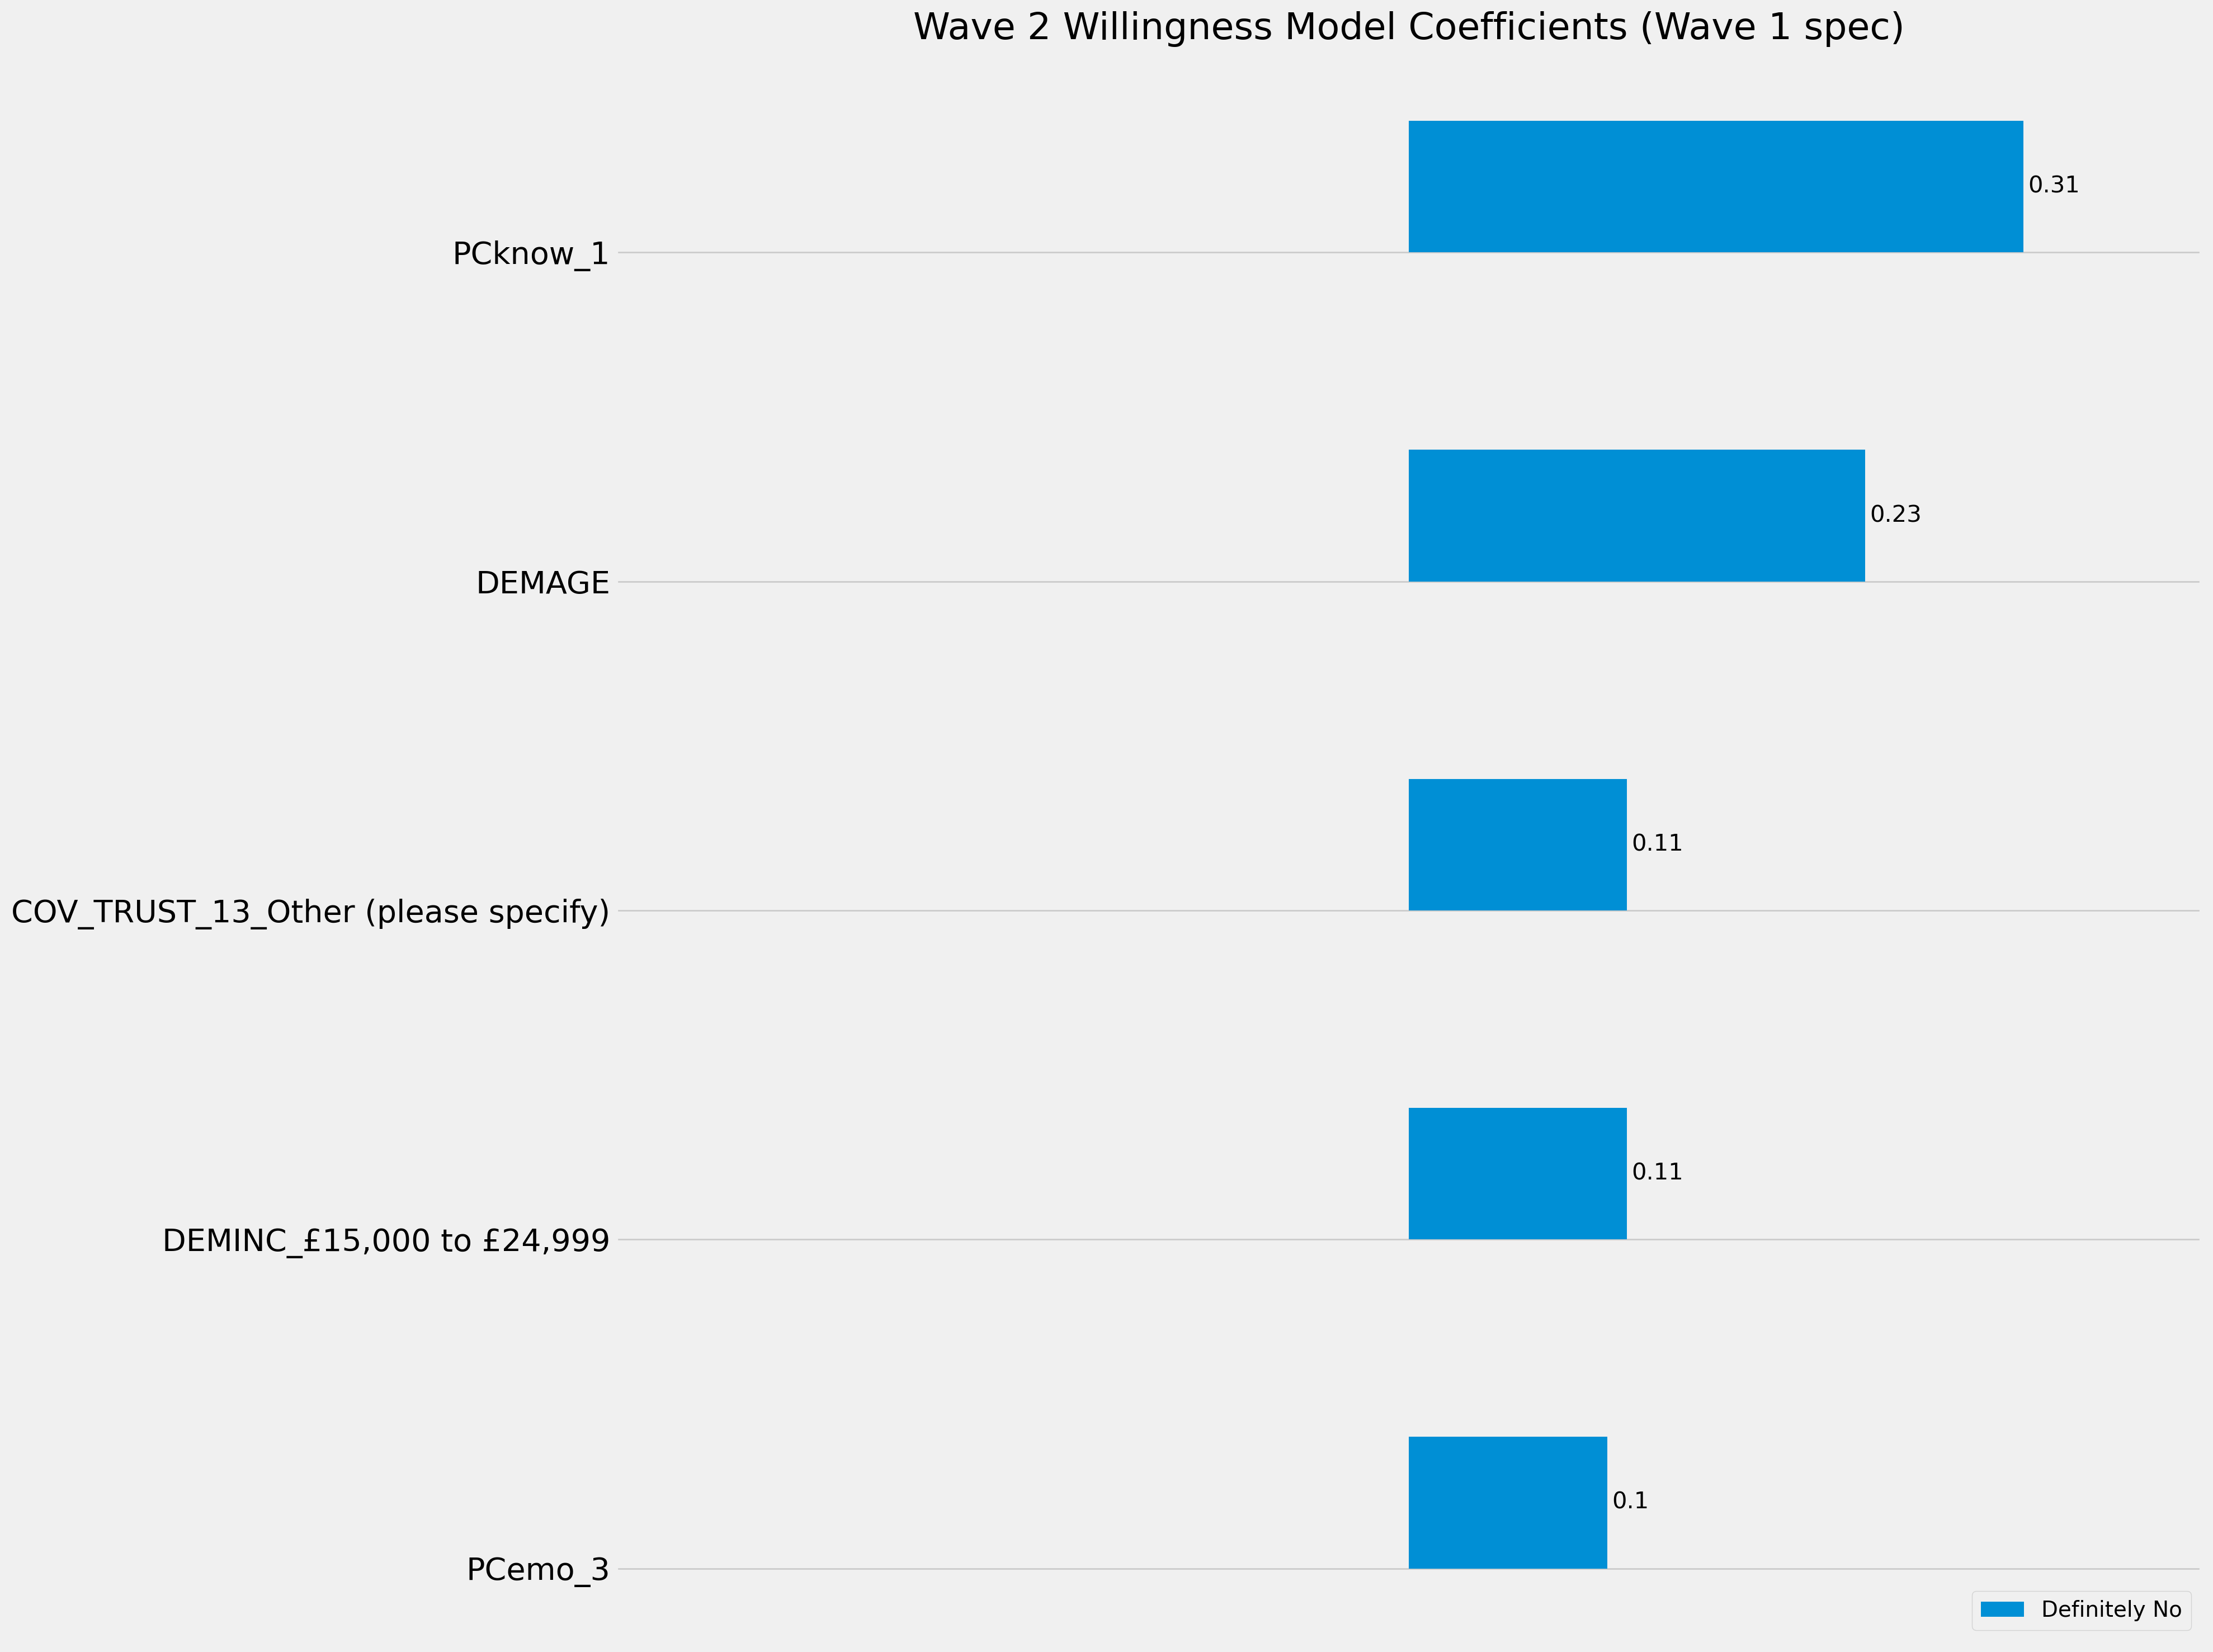

In [14]:
# Plotting coefficients (for class 4 only)
x = np.arange(len(labels))
width = 0.4


fig, ax = plt.subplots(figsize=(20, 15))
rects2 = ax.barh(x + width/2, value_4, width, label='Class 4')

ax.bar_label(rects2, padding=3, fontsize=15)
ax.set_yticks(x, labels, fontsize=20)
ax.set_xticks([])
ax.set_xlim(-0.4, 0.4)
ax.legend(labels=['Definitely No'], loc='lower right')
ax.set_title('Wave 2 Willingness Model Coefficients (Wave 1 spec)', fontsize=24)

fig.tight_layout()

plt.show()

In [15]:
# Full coefficient plotting for classes 1 and 4.
# labels = list(Xtr_final.columns)
# value_1 = list(w1spec.coef_[0])
# value_4 = list(w1spec.coef_[3])

# x = np.arange(len(labels))
# width = 0.4

# fig, ax = plt.subplots(figsize=(20, 30))
# rects1 = ax.barh(x - width/2, value_1, width, label='Class 1')
# rects2 = ax.barh(x + width/2, value_4, width, label='Class 4')

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.set_yticks(x, labels, fontsize=10)
# ax.legend()

# fig.tight_layout()

# plt.show()

 <span style="color:red"> **Section 2b - Generation of new multiclass model, using new features available in wave 2**
This modelling process follows a process consistent with the wave 1 modelling process, but including extra variables not available in wave 1 data. These measures include: Views towards vaccine passports, voting intention, identification of fake news headlines.

In [16]:
# Creating predictor variables
X = w2_intention[["COV_KNOWL_1",
"COV_KNOWL_2",
"COV_KNOWL_3",
"COV_KNOWL_4",
"COV_KNOWL_5",
"COV_KNOWL_6",
"COV_KNOWL_7",
"ANX_1",
"ANX_2",
"ANX_3",
"ANX_4",
"ANX_5",
"ANX_6",
"DEMAGE",
"DREAD",
"VAC_DEC",
"VAC_PASS_1",
"VAC_PASS_2",
"VAC_PASS_3",
"VAC_PASS_4",
"VAC_PASS_5",
"VAC_PASS_6",
"VAC_PASS_7",
"MIST_1_Real",
"MIST_2_Real",
"MIST_3_Real",
"MIST_4_Real",
"MIST_5_Real",
"MIST_6_Real",
"MIST_7_Real",
"MIST_8_Real",
"MIST_9_Real",
"MIST_10_Real",
"MIST_11_Real",
"MIST_12_Real",
"MIST_13_Real",
"MIST_14_Real",
"MIST_15_Real",
"MIST_16_Real",
"MIST_17_Real",
"MIST_18_Real",
"MIST_19_Real",
"MIST_20_Real",
"DEMREG_East of England",
"DEMREG_Greater London",
"DEMREG_North East",
"DEMREG_North West",
"DEMREG_Northern Ireland",
"DEMREG_Scotland",
"DEMREG_South East",
"DEMREG_South West",
"DEMREG_Wales",
"DEMREG_West Midlands",
"DEMREG_Yorkshire and The Humber",
"DEMSEX_Male",
"DEMEDU_2+ A levels or equivalents",
"DEMEDU_5+ GCSE, O-levels, 1 A level, or equivalents",
"DEMEDU_Apprenticeship",
"DEMEDU_No academic qualifications",
"DEMEDU_Other",
"DEMEDU_Undergraduate or postgraduate degree",
"DEMWRK_Retired",
"DEMWRK_Student",
"DEMWRK_Unable to work",
"DEMWRK_Unemployed",
"DEMWRK_Working full-time",
"DEMWRK_Working part-time",
"DEMREL_Christian",
"DEMREL_Muslim",
"DEMREL_Other",
"DEMINC_Under £15,000",
"DEMINC_£15,000 to £24,999",
"DEMINC_£25,000 to £34,999",
"DEMINC_£35,000 to £44,999",
"DEMINC_£45,000 to £54,999",
"DEMINC_£55,000 to £64,999",
"DEMINC_£65,000 to £99,999",
"COV_INV_Yes",
"DEMNHS_Yes",
"COV_SHIELD_Yes",
"Q71_Green Party",
"Q71_Labour",
"Q71_Liberal Democrat",
"Q71_Local independent",
"Q71_Other/Not eligible",
"Q71_Reform Party ",
"Q71_SNP",
"COV_TRUST_1_National television",
"COV_TRUST_2_Satellite / international television channels",
"COV_TRUST_3_Radio",
"COV_TRUST_4_Newspapers",
"COV_TRUST_5_Social media (Facebook, Twitter, etc)",
"COV_TRUST_6_National public health authorities (such as the NHS or Public Health England / Wales)",
"COV_TRUST_7_Healthcare workers",
"COV_TRUST_8_International health authorities (such as The World Health Organization)",
"COV_TRUST_9_Government websites",
"COV_TRUST_10_The internet or search engines",
"COV_TRUST_11_Family and friends",
"COV_TRUST_12_Work, school, or college",
"COV_TRUST_13_Other (please specify)"]]

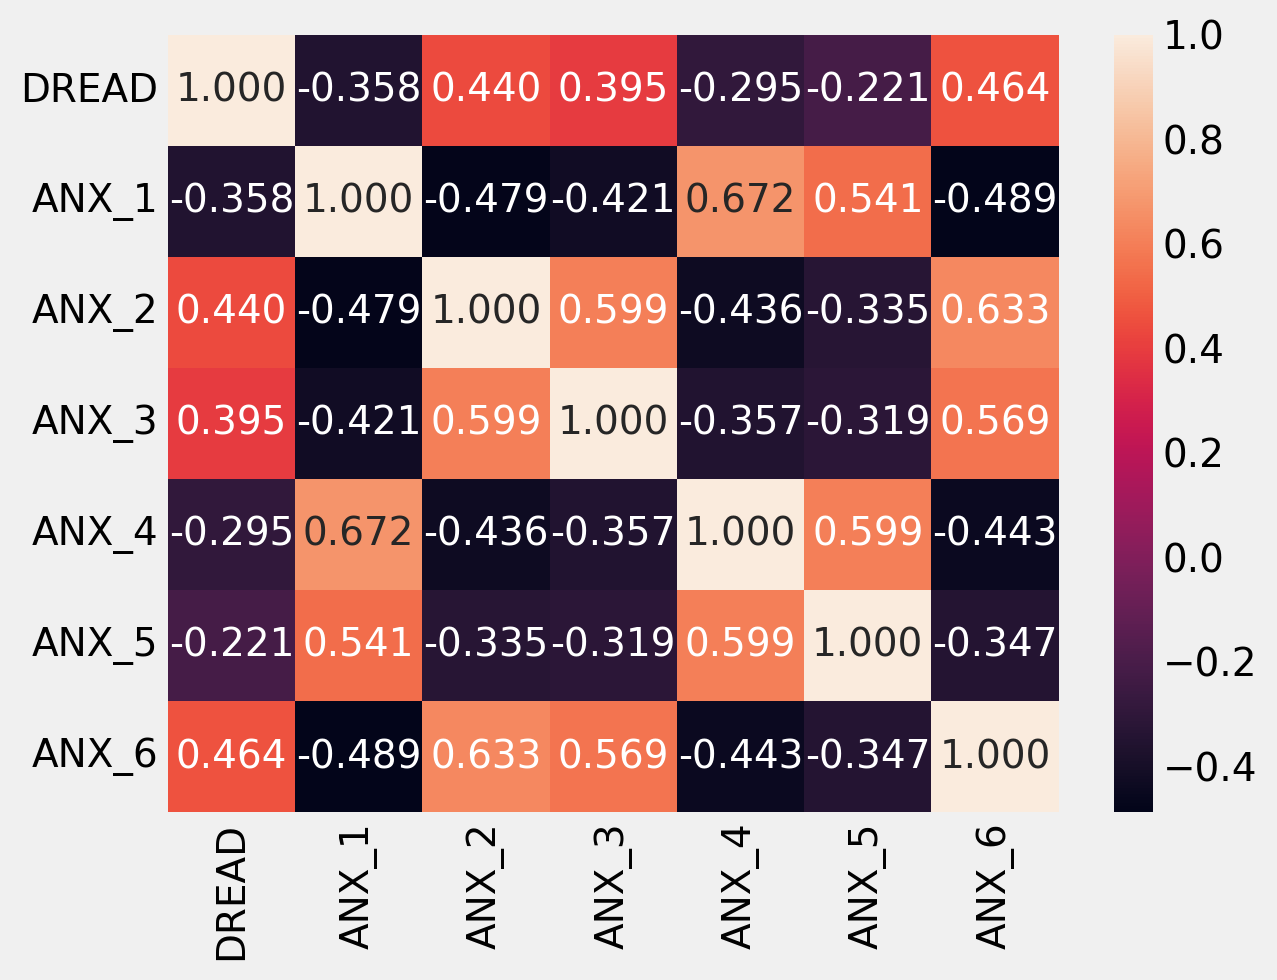

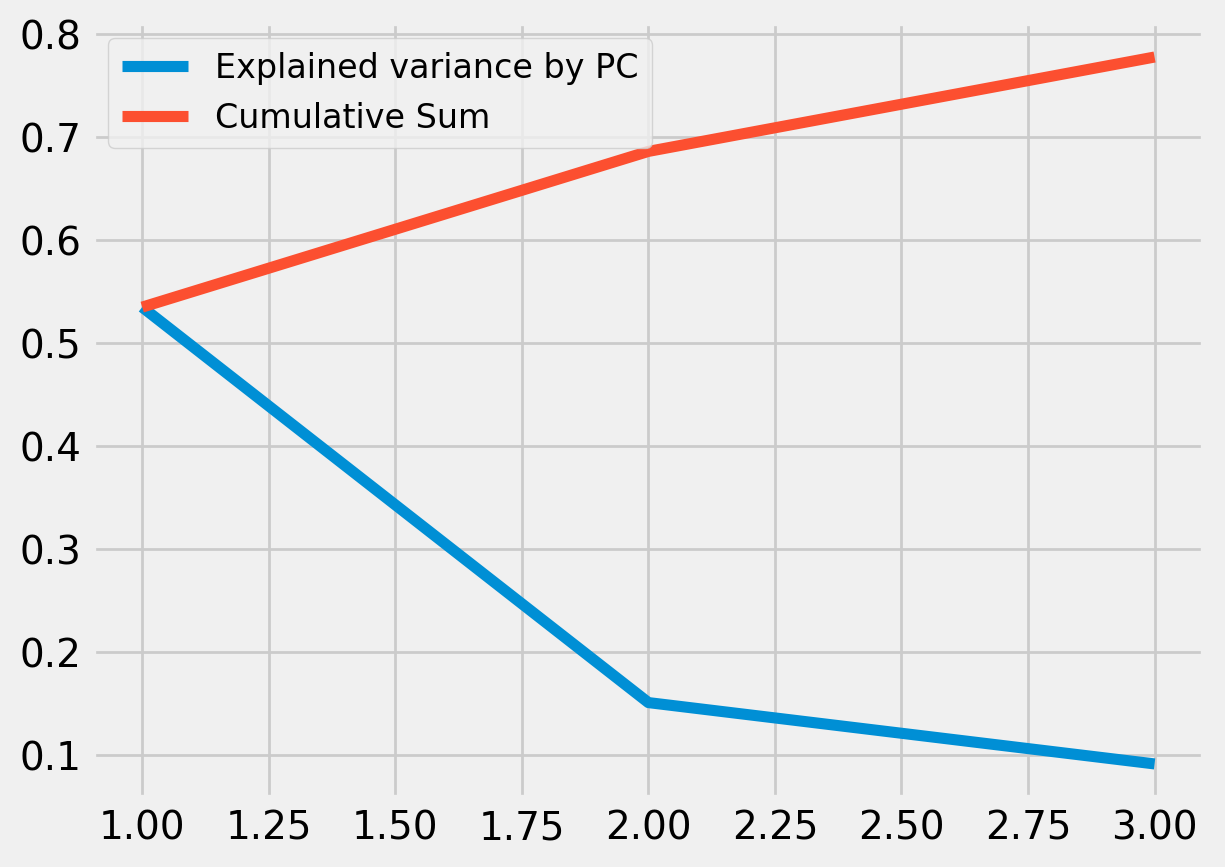

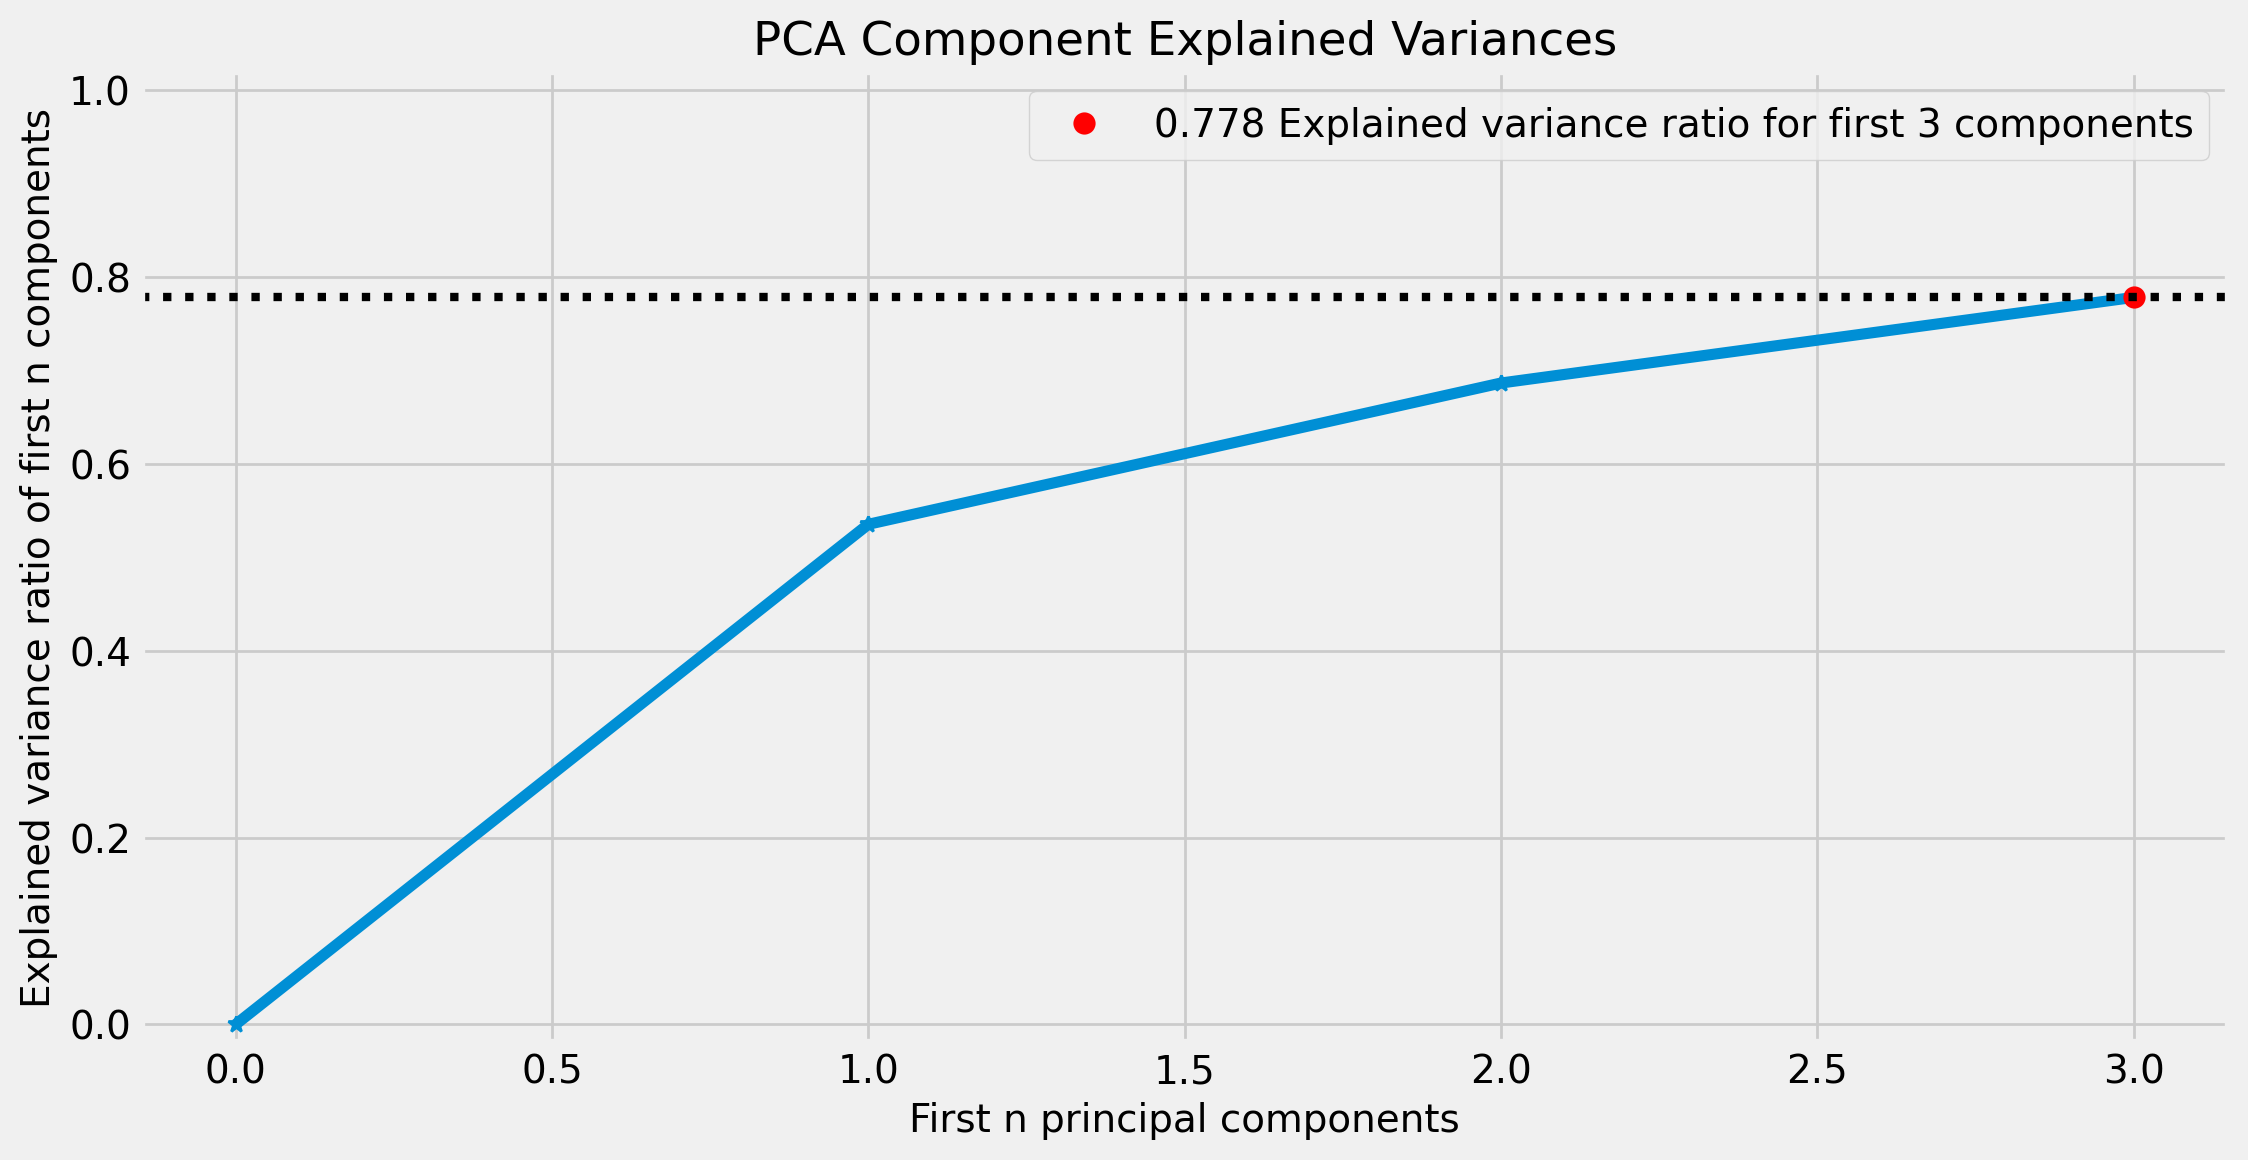

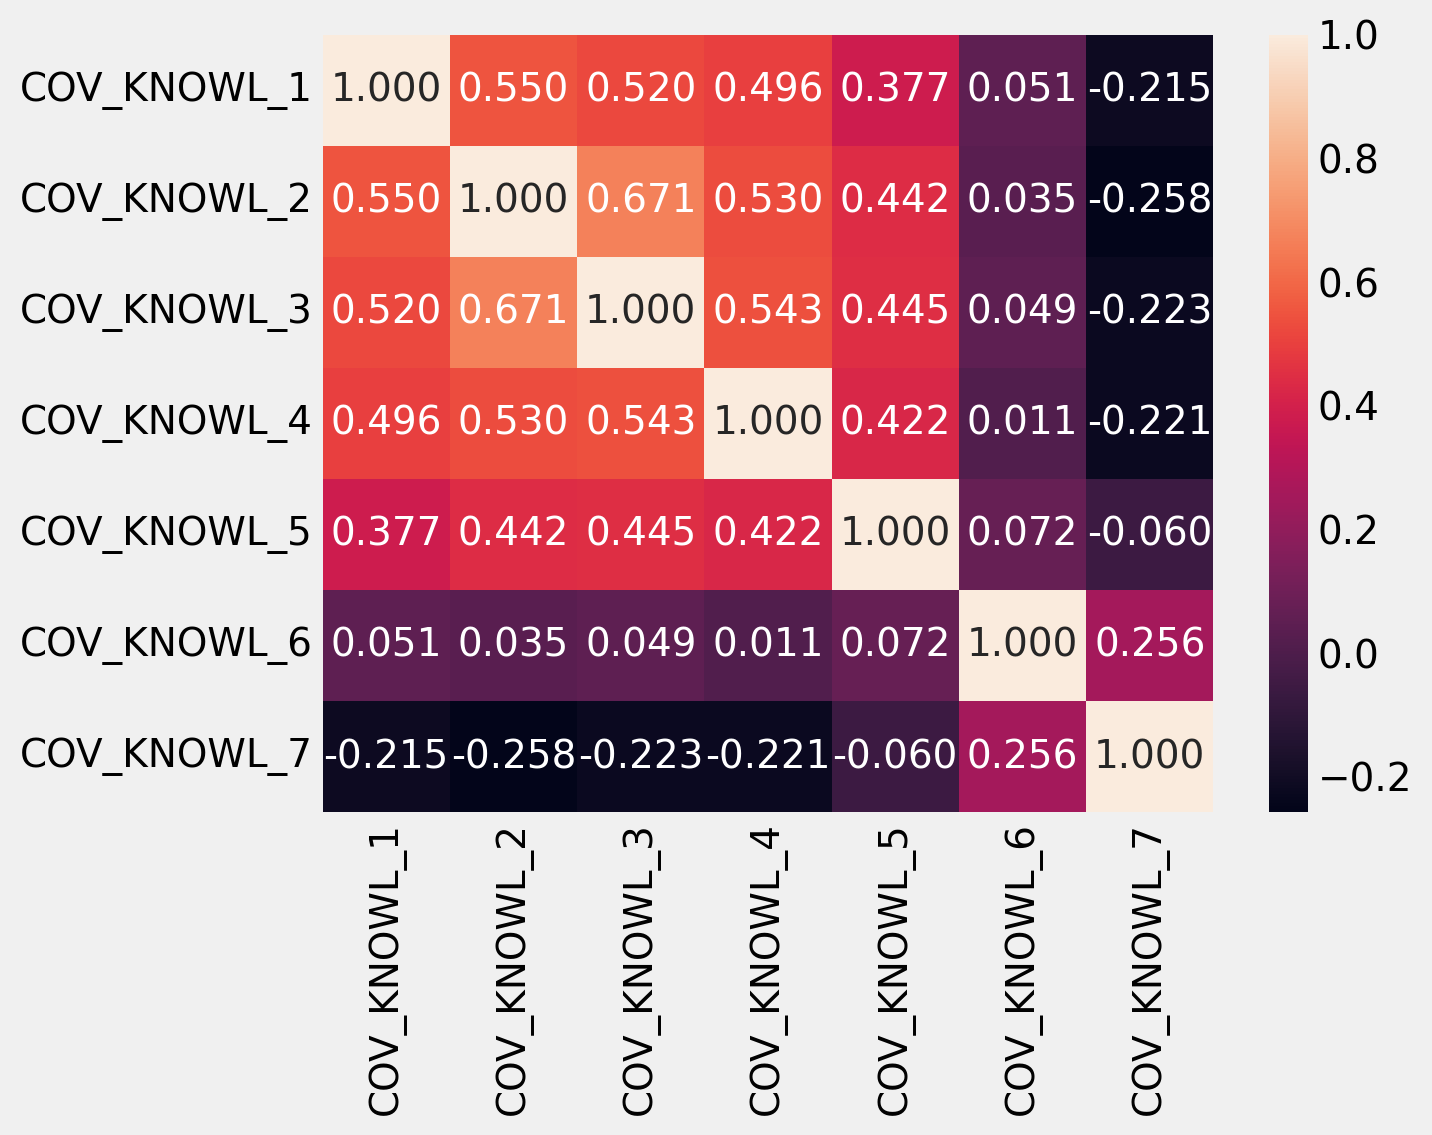

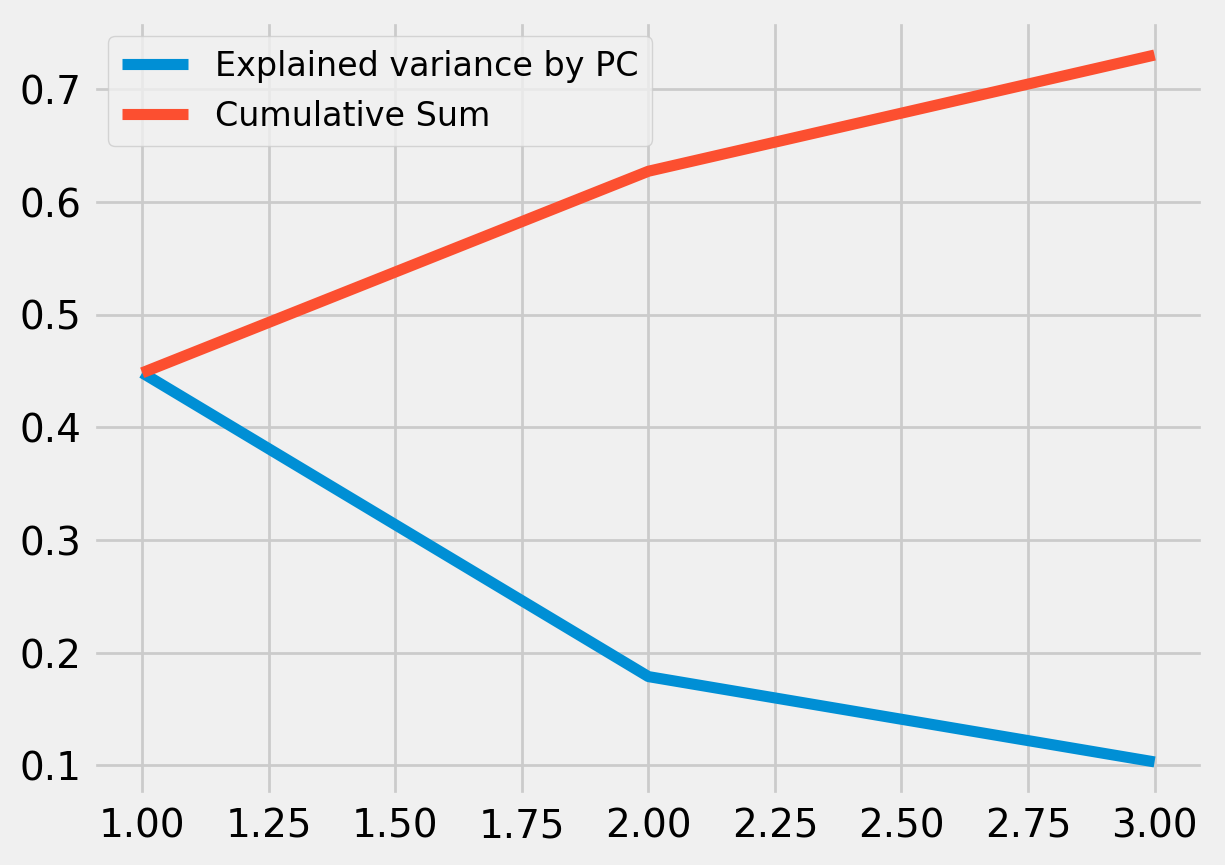

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


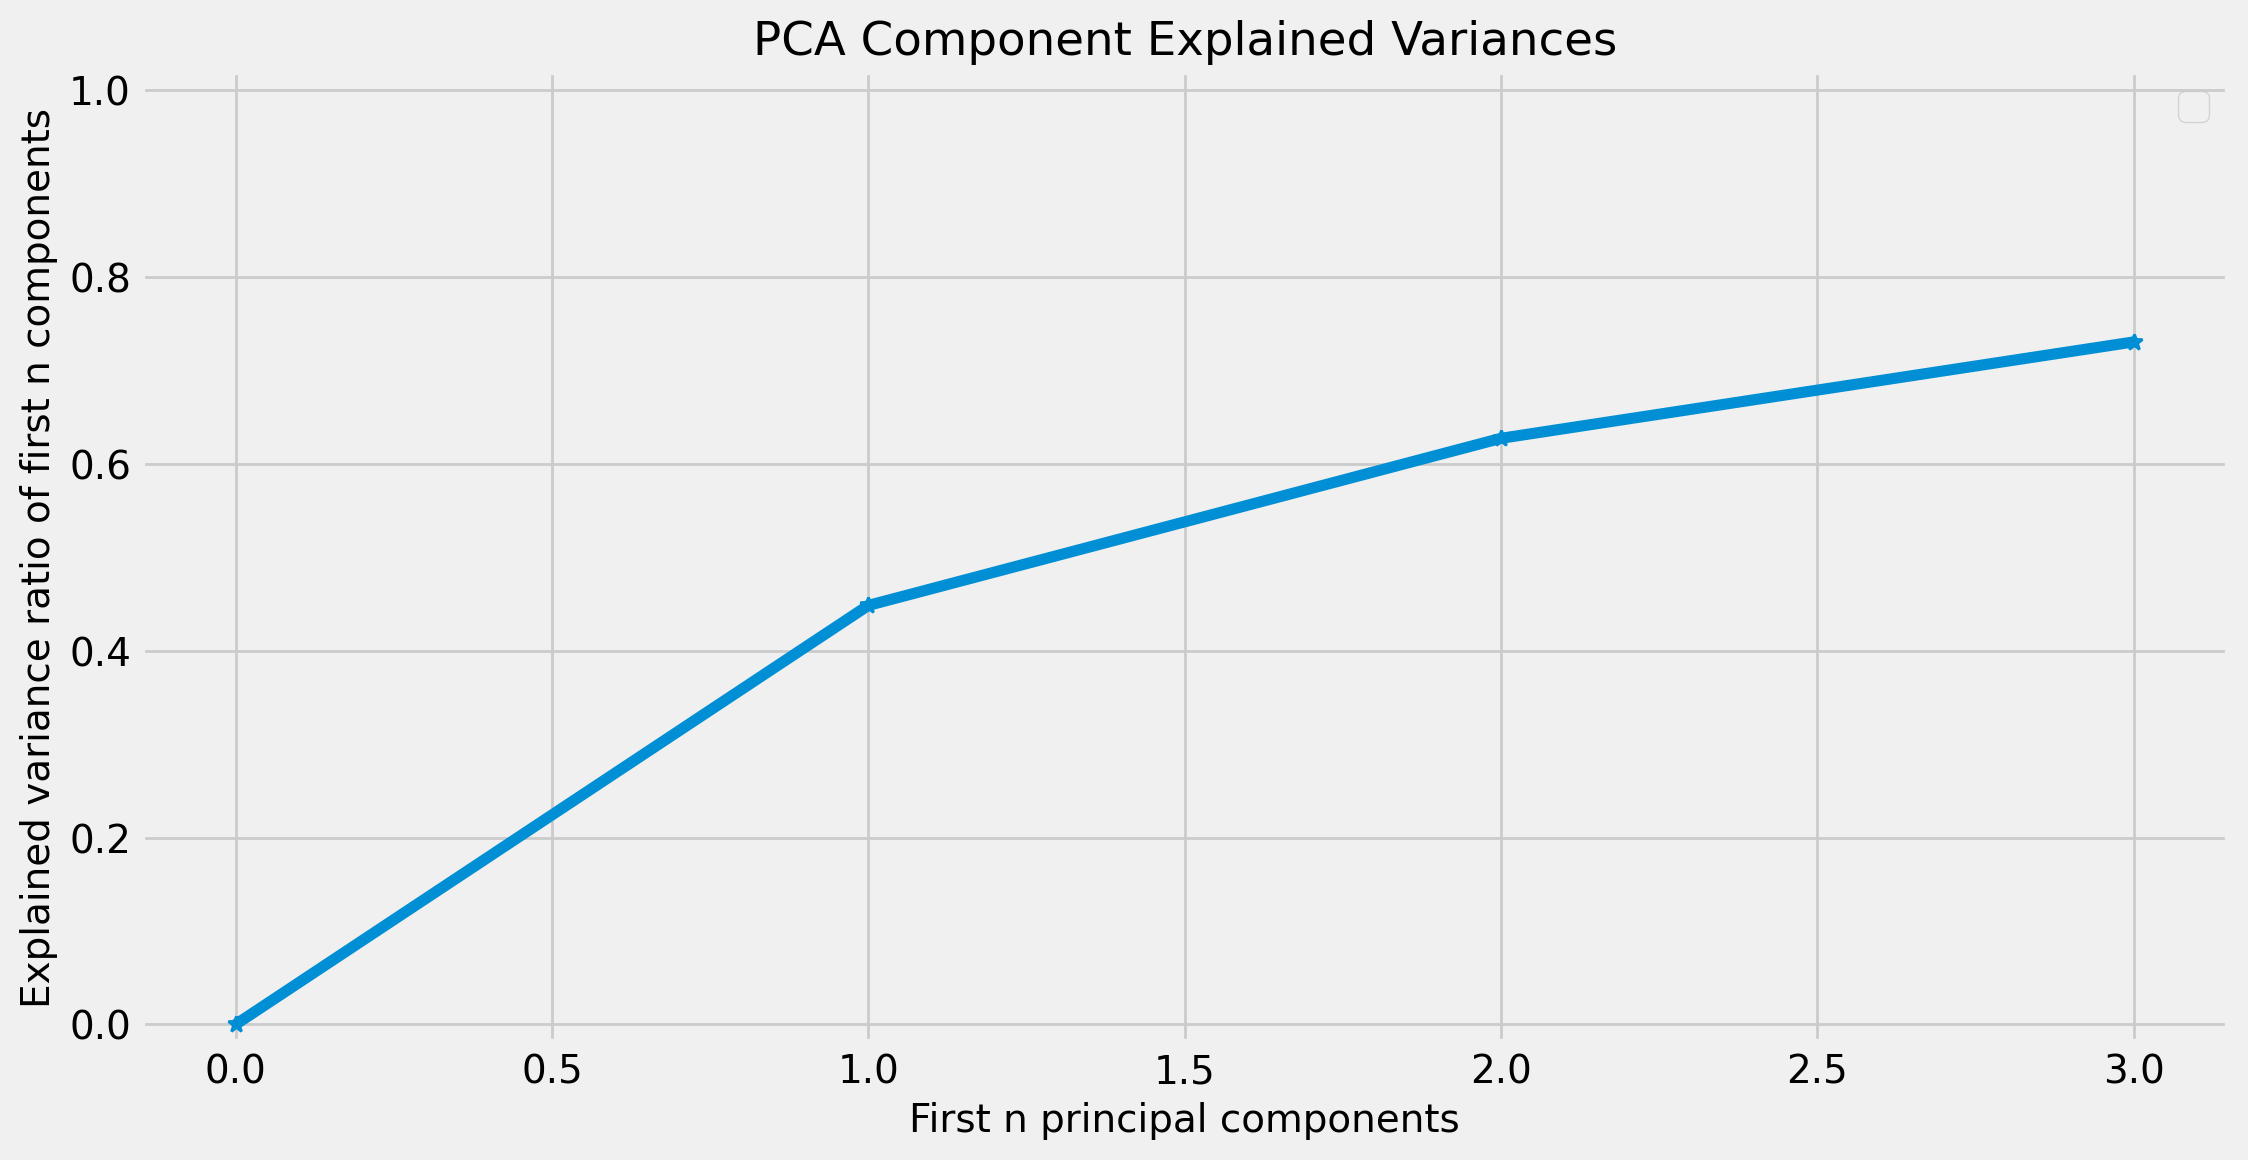

In [17]:
# RUNNING PREPROCESSING
# Train test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=3)

# Scaling
scaler = StandardScaler()
Xstd_train = scaler.fit_transform(X_train)
Xstd_test = scaler.transform(X_test)

# Applying PCA to emotion vars
emotion_vars = ['DREAD', 'ANX_1', 'ANX_2', 'ANX_3', 'ANX_4', 'ANX_5',
     'ANX_6']

X[emotion_vars].corr()
sns.heatmap(X[emotion_vars].corr(), annot=True, fmt='.3f')
plt.show()

X_traindf = pd.DataFrame(Xstd_train, columns=list(X.columns))
X_testdf = pd.DataFrame(Xstd_test, columns=list(X.columns))

pca_emomulti = PCA(n_components=3)
pca_emomulti.fit(X_traindf[emotion_vars])

plt.plot(range(1, pca_emomulti.n_components_+1), pca_emomulti.explained_variance_ratio_, label="Explained variance by PC")
plt.plot(range(1, pca_emomulti.n_components_+1), pca_emomulti.explained_variance_ratio_.cumsum(), label="Cumulative Sum")
plt.legend(fontsize=12)
plt.show()

plot_pca_component_variance(pca_emomulti, target_explained_variance=0.75, figsize=(12, 6))
plt.show()

pca_emomulti.explained_variance_ratio_.cumsum()

emo_tran_train = pd.DataFrame(pca_emomulti.transform(X_traindf[emotion_vars]),
                             columns=[f'PCemo_{i+1}' for i in range(pca_emomulti.n_components_)])
emo_tran_test = pd.DataFrame(pca_emomulti.transform(X_testdf[emotion_vars]),
                             columns=[f'PCemo_{i+1}' for i in range(pca_emomulti.n_components_)])

merged_train = pd.merge(X_traindf, emo_tran_train, left_index=True, right_index=True)
merged_train.drop(emotion_vars, axis=1, inplace=True)
merged_test = pd.merge(X_testdf, emo_tran_test, left_index=True, right_index=True)
merged_test.drop(emotion_vars, axis=1, inplace=True)



# Applying PCA to knowledge vars
knowledge_vars = ['COV_KNOWL_1', 'COV_KNOWL_2',
     'COV_KNOWL_3', 'COV_KNOWL_4', 'COV_KNOWL_5', 'COV_KNOWL_6',
     'COV_KNOWL_7']

X[knowledge_vars].corr()
sns.heatmap(X[knowledge_vars].corr(), annot=True, fmt='.3f')
plt.show()

pca_knomulti = PCA(n_components=3)
pca_knomulti.fit(merged_train[knowledge_vars])

plt.plot(range(1, pca_knomulti.n_components_+1), pca_knomulti.explained_variance_ratio_, label="Explained variance by PC")
plt.plot(range(1, pca_knomulti.n_components_+1), pca_knomulti.explained_variance_ratio_.cumsum(), label="Cumulative Sum")
plt.legend(fontsize=12)
plt.show()

plot_pca_component_variance(pca_knomulti, target_explained_variance=0.75, figsize=(12, 6))
plt.show()

pca_knomulti.explained_variance_ratio_.cumsum()

know_tran_train = pd.DataFrame(pca_knomulti.transform(merged_train[knowledge_vars]),
                             columns=[f'PCknow_{i+1}' for i in range(pca_knomulti.n_components_)])
know_tran_test = pd.DataFrame(pca_knomulti.transform(merged_test[knowledge_vars]),
                             columns=[f'PCknow_{i+1}' for i in range(pca_knomulti.n_components_)])

Xtr_final = pd.merge(merged_train, know_tran_train, left_index=True, right_index=True)
Xtr_final.drop(knowledge_vars, axis=1, inplace=True)
Xte_final = pd.merge(merged_test, know_tran_test, left_index=True, right_index=True)
Xte_final.drop(knowledge_vars, axis=1, inplace=True)

# Applying SMOTE Overbalancing to train data
over = SMOTE()
X_smote, y_smote = over.fit_resample(Xtr_final, y_train)

In [18]:
# Initialising score dictionary and running base estimators
scores = {
    'Model Name': [],
    'Train Accuracy': [],
    'Cross Validation Accuracy': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test Recall': [],
    'Test F1 Score': [],
    'Cross Validation ROC AUC': [],
    'Test ROC AUC Score': [],
    'Variance': [],
    'Bias': [],
    'Variance/bias': []
}

models = [KNeighborsClassifier(),
          LogisticRegression(multi_class='ovr', max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier()]

for model in models:
    print(f'Model: {model}')
    model_run(model, X_smote, Xte_final, y_smote, y_test)
    print()
    print('-----------------------')
    print()

Model: KNeighborsClassifier()
Training accuracy score: 0.8653032440056417
5-Fold Cross Val accuracy score: 0.8238771181502459
Test accuracy score: 0.336

5-Fold Cross Val ROCAUC score: 0.9475635938699659
ROC_AUC_SCORE Test: 0.6183271181520573

[[101 180  45  29]
 [  8  45  18   9]
 [  4  10  12  10]
 [  2   9   8  10]]

              precision    recall  f1-score   support

         1.0       0.88      0.28      0.43       355
         2.0       0.18      0.56      0.28        80
         3.0       0.14      0.33      0.20        36
         4.0       0.17      0.34      0.23        29

    accuracy                           0.34       500
   macro avg       0.34      0.38      0.28       500
weighted avg       0.67      0.34      0.38       500



Variance: 0.8318
Bias sq: 1.2176
Variance/Bias: 2.0494

-----------------------

Model: LogisticRegression(max_iter=1000, multi_class='ovr')
Training accuracy score: 0.7023977433004231
5-Fold Cross Val accuracy score: 0.6807194524081455
Test

**Model Results**

We see a similar pattern w.r.t estimator performance as we have seen in previous rounds of modelling, although the differences observed previously are less pronounced - all models appear to perform relatively similarly w.r.t class 3 and 4 recall. Again, my preference is to choose the logistic classifier, as it shows less sign of overfitting on the train data (train and test scores are somewhat more consistent than for other classifiers).

Interesting to note is that in general, the class 4 recall is poorer than the corresponding scores observed in wave 1, although class 3 recall is somewhat improved.

**Model Optimisation**
Model optimisation follows the same process as per wave 1 modelling:

- Grid searching the Logistic classifier's parameters such that the model's ROC AUC score is maximised
- Grid searching the Logistic classifier's parameters such that the model's average recall score is maximised

In addition to the optimised models two further models will be run for comparison purposes:
- A model using the optimised wave 1 model parameters 
- An Ada boosted logistic classifier.


In [19]:
# LOGISTIC REGRESSION Grid search w.r.t ROC AUC. 
# Note that the code has been commented to prevent accidentally running code requiring significant computational power

# log_params = {'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9, 0.99],
#               'C': np.logspace(-3, 0, 50)}

# log = LogisticRegression(multi_class='ovr', penalty='elasticnet', solver='saga', max_iter=1000)

# roclog_gr = GridSearchCV(log, log_params, scoring='roc_auc_ovr', n_jobs=2, cv=5, verbose=1)
# roclog_gr.fit(X_smote, y_smote)
# w2logbest_roc = roclog_gr.best_estimator_
# joblib.dump(w2logbest_roc, 'w2optimum_logisticroc.jlib')

In [20]:
roclog = joblib.load('w2optimum_logisticroc.jlib')

In [21]:
# LOGISTIC REGRESSION Grid search w.r.t Recall. 
# Note that the code has been commented to prevent accidentally running code requiring significant computational power

# log_params = {'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9, 0.99],
#               'C': np.logspace(-3, 0, 50)}

# log = LogisticRegression(multi_class='ovr', penalty='elasticnet', solver='saga', max_iter=1000)

# reclog_gr = GridSearchCV(log, log_params, scoring='recall', n_jobs=2, cv=5, verbose=1)
# reclog_gr.fit(X_smote, y_smote)
# w2logbest_rec = reclog_gr.best_estimator_
# joblib.dump(w2logbest_rec, 'w2optimum_logisticrec.jlib')

In [22]:
reclog = joblib.load('w2optimum_logisticrec.jlib')

In [23]:
# Instantiating optimised wave 1 model specification.
w1opt = LogisticRegression(C=0.001, l1_ratio=0.1, max_iter=1000, multi_class='ovr',
                   penalty='elasticnet', solver='saga')

In [24]:
# Instantiating booster Logistic model
base_estimator = LogisticRegression(multi_class='ovr')
multiboost = AdaBoostClassifier(base_estimator=base_estimator,
                               n_estimators=100,
                               random_state=1)

In [25]:
# Initialising score dictionary and running optimised estimators
scores = {
    'Model Name': [],
    'Train Accuracy': [],
    'Cross Validation Accuracy': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test Recall': [],
    'Test F1 Score': [],
    'Cross Validation ROC AUC': [],
    'Test ROC AUC Score': [],
    'Variance': [],
    'Bias': [],
    'Variance/bias': []
}
models = [roclog, reclog, w1opt, multiboost]

for model in models:
    print(f'Model: {model}')
    model_run(model, X_smote, Xte_final, y_smote, y_test)
    print()
    print('-----------------------')
    print()

Model: LogisticRegression(l1_ratio=0.99, max_iter=1000, multi_class='ovr',
                   penalty='elasticnet', solver='saga')


C:\Users\laure\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\laure\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\laure\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\laure\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\laure\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\laure\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Training accuracy score: 0.7004583921015515
5-Fold Cross Val accuracy score: 0.6817771872984795
Test accuracy score: 0.618

5-Fold Cross Val ROCAUC score: 0.8842254099346313
ROC_AUC_SCORE Test: 0.725182854592106

[[251  53  33  18]
 [ 25  29  15  11]
 [  6   7  16   7]
 [  4   4   8  13]]

              precision    recall  f1-score   support

         1.0       0.88      0.71      0.78       355
         2.0       0.31      0.36      0.34        80
         3.0       0.22      0.44      0.30        36
         4.0       0.27      0.45      0.33        29

    accuracy                           0.62       500
   macro avg       0.42      0.49      0.44       500
weighted avg       0.70      0.62      0.65       500



Variance: 1.0542
Bias sq: 0.8256
Variance/Bias: 1.8798

-----------------------

Model: LogisticRegression(C=0.001, l1_ratio=0.1, max_iter=1000, multi_class='ovr',
                   penalty='elasticnet', solver='saga')
Training accuracy score: 0.5957334273624824
5-Fold C

In [26]:
# Obtaining score summary
scoring = pd.DataFrame.from_dict(scores)
scoring

,Model Name,Train Accuracy,Cross Validation Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Cross Validation ROC AUC,Test ROC AUC Score,Variance,Bias,Variance/bias
0,"LogisticRegression(l1_ratio=0.99, max_iter=100...",0.700458,0.681777,0.618,0.704392,0.618,0.650346,0.884225,0.725183,1.0542,0.8256,1.8798
1,"LogisticRegression(C=0.001, l1_ratio=0.1, max_...",0.595733,0.572989,0.648,0.716625,0.648,0.673544,0.828245,0.770059,1.1005,0.8144,1.9149
2,"LogisticRegression(C=0.001, l1_ratio=0.1, max_...",0.595733,0.572989,0.648,0.716625,0.648,0.673544,0.828245,0.770059,1.1005,0.8144,1.9149
3,AdaBoostClassifier(base_estimator=LogisticRegr...,0.511636,0.513939,0.402,0.633461,0.402,0.456319,0.816514,0.655727,0.8510,0.9816,1.8326


 <span style="color:red"> **Optimised model performance**

As in wave 1, the optimised best estimator is a Logistic Regression optimised to maximise recall. Interestingly, the best estimator holds exactly the same parameters as the optimised wave 1 model, suggesting the data is similar enough that the optimisation remains consistent.

Class 3 and 4 recall with this model is improved on the non-optimised version, with Class 3 in particular classified more effectively than in wave 1, although class 4 recall continues to lag behind the wave 1 model. The boosted ensemble model doesn't represent an improvement on the optimised single Logistic estimator.

The preferred model to proceed with is the 'recall-optimised' model, which shares the parameters with the wave 1 best estimator.

**Section 2d - Deep dive into preferred models & coefficient analysis**

The inclusion of extra wave 2 predictors does seem to improve the model's overall performance across all classes. The overall ROC AUC score is higher than the wave 1 model, and across all classes we observe that the ROC AUC is improved, although class 2 again represents a greater challenge to predict compared to other classes.

In terms of predictor importance, as observed above, the knowledge scale, and age emerge as important predictors of vaccine skepticism. Having received an invitation to receive a vaccine also predicts skepticism - this could be due to some self-selection bias - those still in the willingness sample set who have received a vaccine invite are more likely to have actively decided not to take a vaccine, hence caution should be advised in interpreting this deeply.

Trust in 'mainstream' media sources, agreement with a set of vaccination pass statements (e.g. passes should be obligatory for entry into social events etc), and higher income levels again indicate high levels of vaccine acceptance.

C:\Users\laure\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


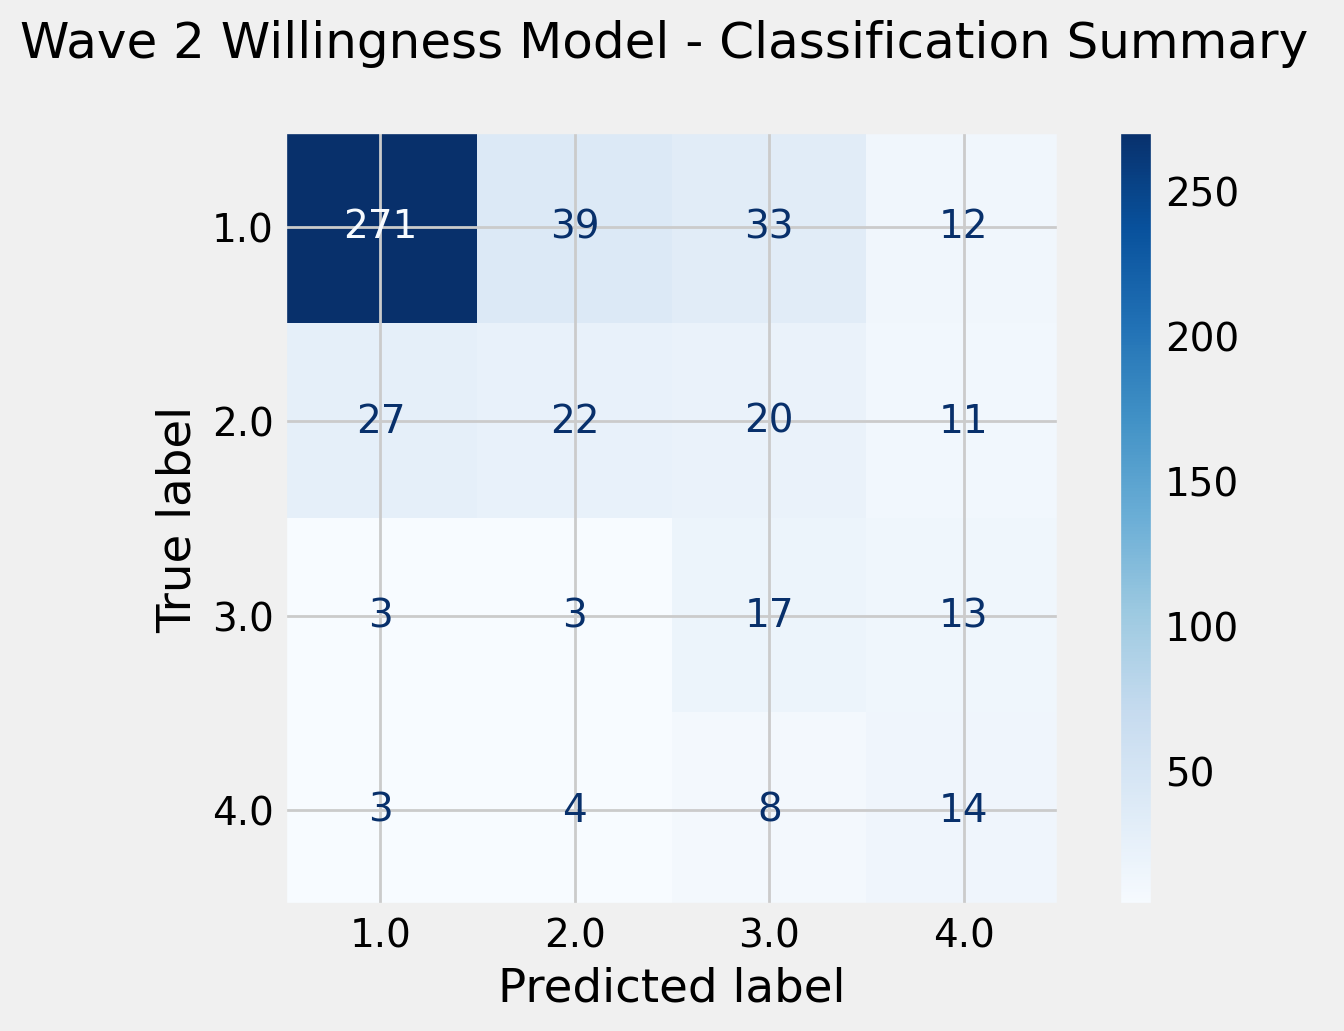

In [27]:
plot_confusion_matrix(reclog, Xte_final, y_test, cmap='Blues')
plt.title("Wave 2 Willingness Model - Classification Summary \n", fontsize=18)
plt.show()

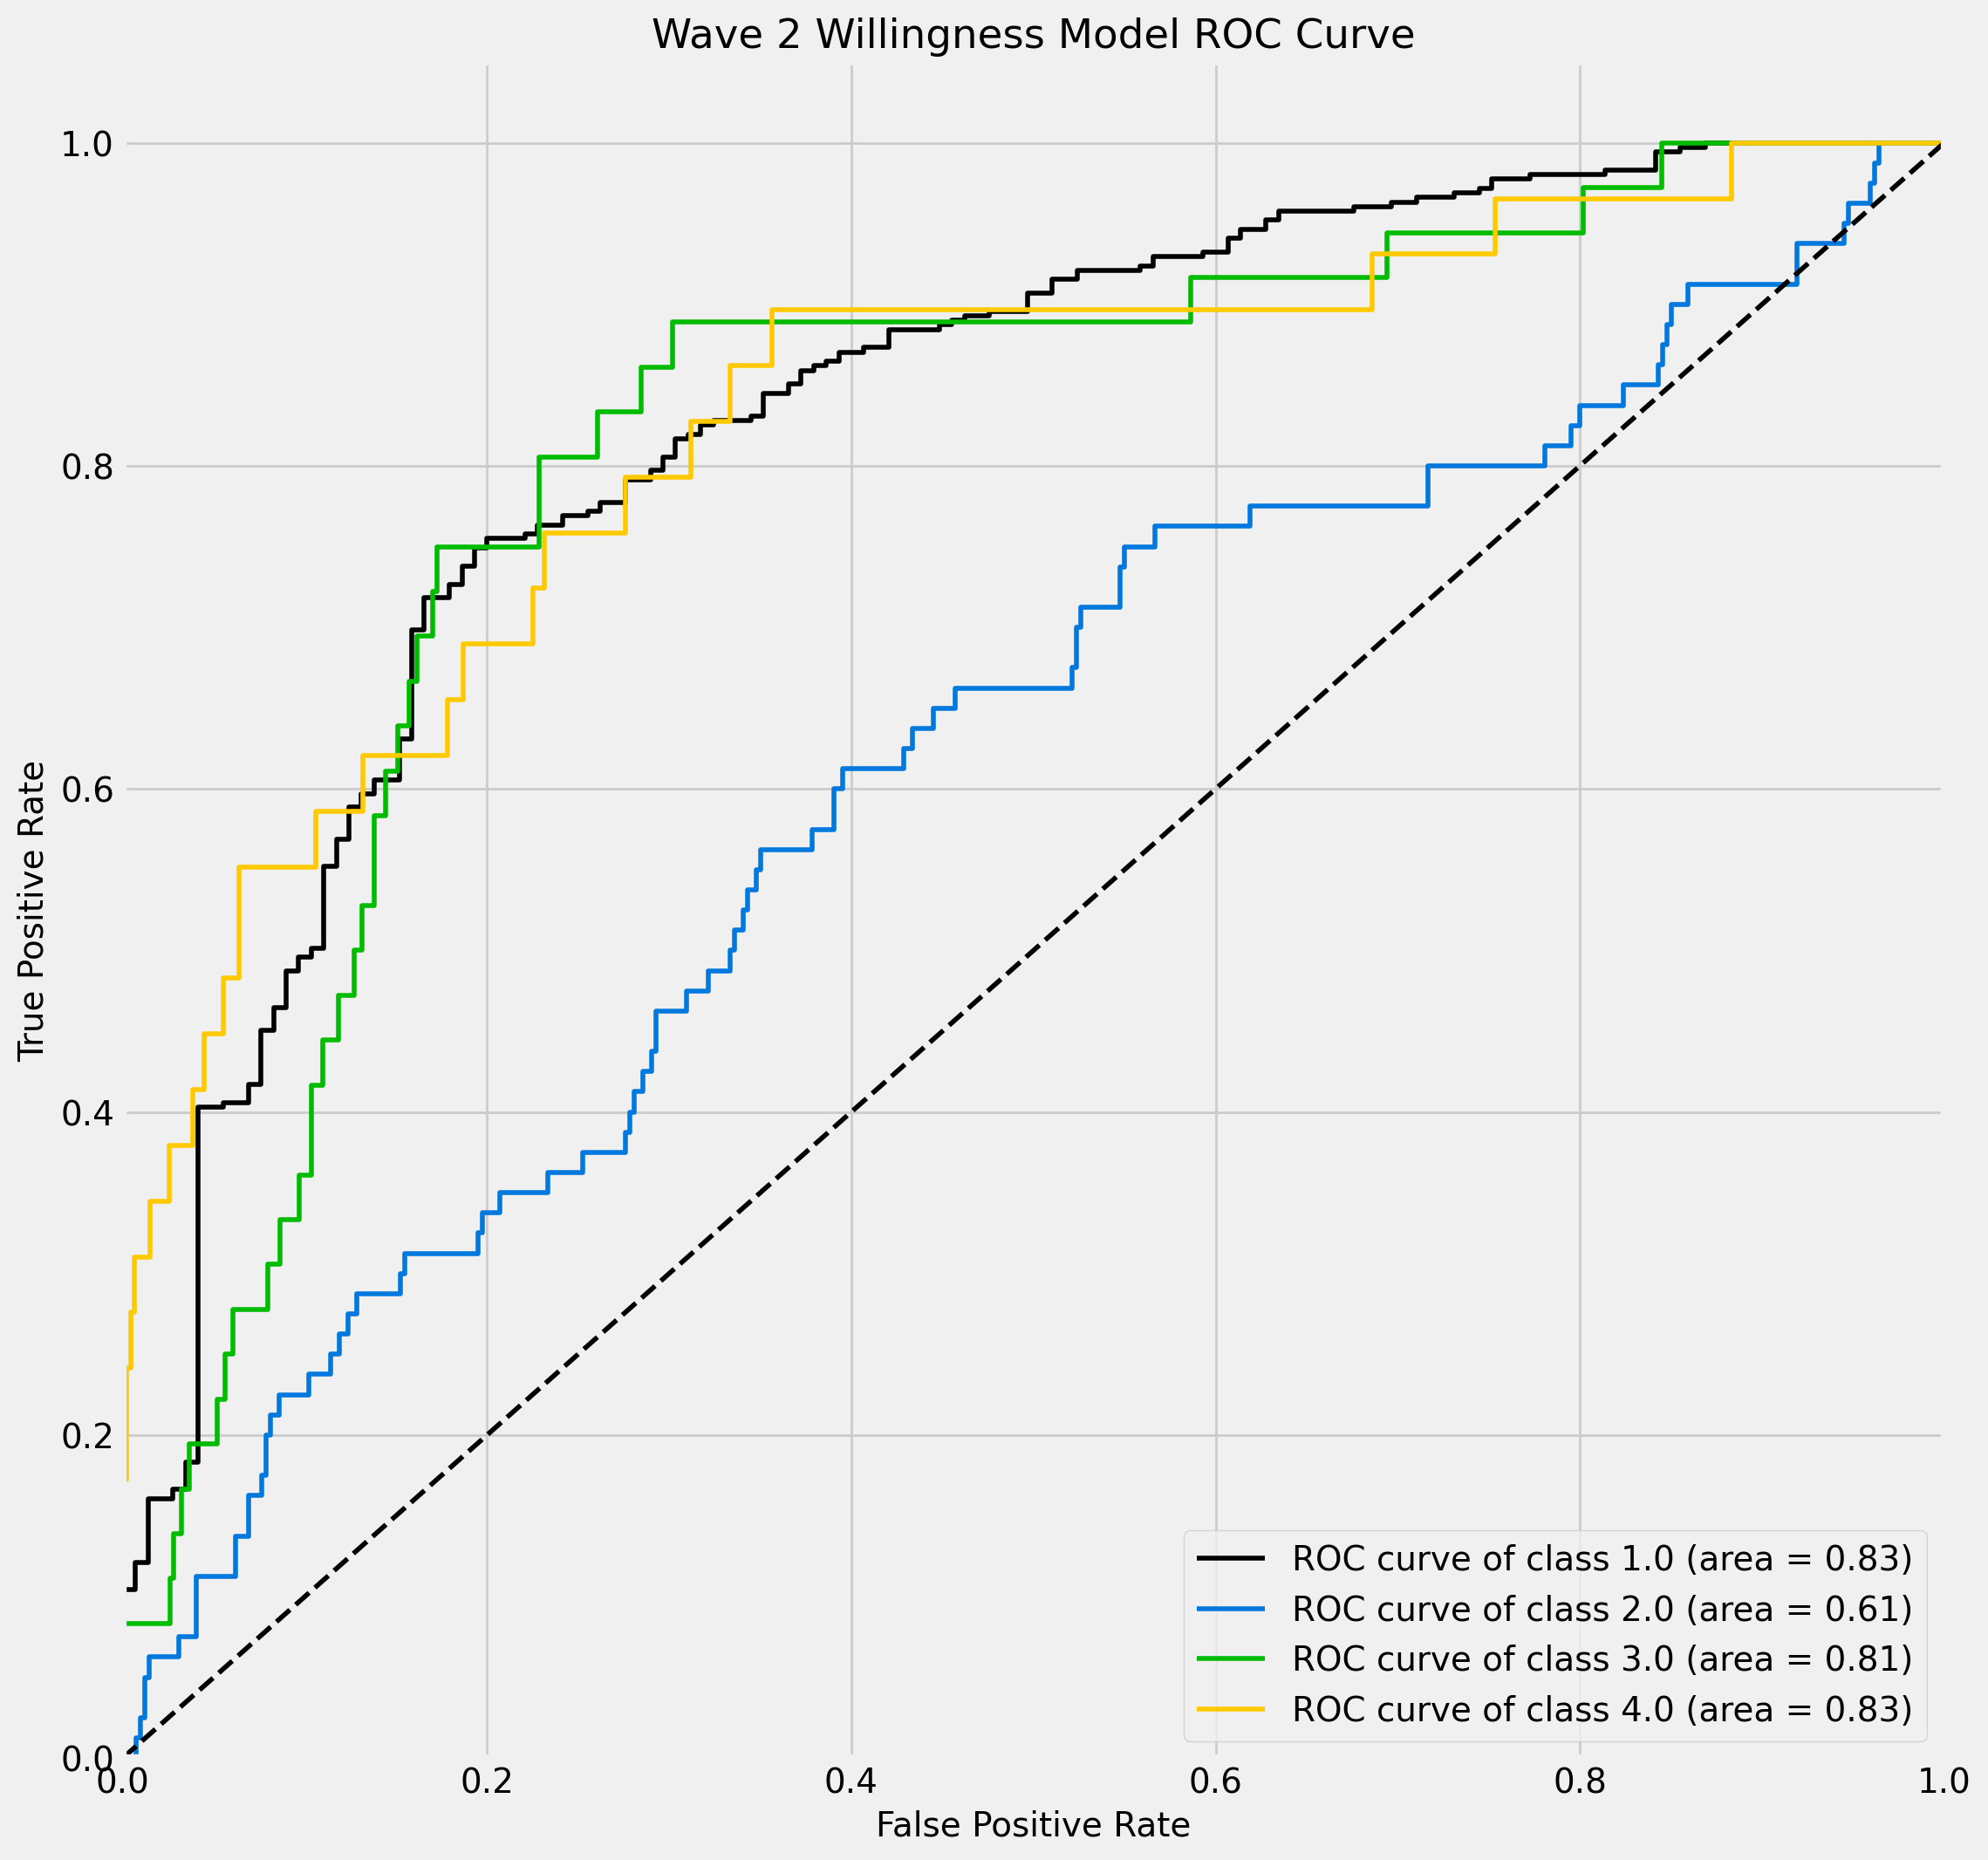

In [28]:
fig, ax = plt.subplots(figsize=(12, 12))
probas = reclog.predict_proba(Xte_final)
plot_roc(y_test, probas, title='Wave 2 Willingness Model ROC Curve', plot_micro=False, plot_macro=False, figsize=(10, 10), ax=ax)
plt.show()

In [29]:
# fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
# probas = reclog.predict_proba(Xte_final)
# probas2 = roclog.predict_proba(Xte_final)
# plot_roc(y_test, probas, title='ROC Curve Recall optimisation', plot_micro=False, plot_macro=False, figsize=(10, 10), ax=ax[0])
# plot_roc(y_test, probas2, title='ROC Curves ROC AUC optimisation', plot_micro=False, plot_macro=False, figsize=(10, 10), ax=ax[1])
# plt.show()

In [30]:
# Obtaining multiclass coefficients

value_1 = list(np.exp(reclog.coef_[0]))
value_2 = list(np.exp(reclog.coef_[1]))
value_3 = list(np.exp(reclog.coef_[2]))
value_4 = list(np.exp(reclog.coef_[3]))


coef_data = pd.DataFrame(zip(Xtr_final.columns, value_1, value_2, value_3, value_4), columns = ['Feature names', 'Coefficients Value 1', 'Coefficients Value 2', 'Coefficients Value 3', 'Coefficients Value 4'])
coef_data.sort_values(by='Coefficients Value 1', ascending=False).head(20)

,Feature names,Coefficients Value 1,Coefficients Value 2,Coefficients Value 3,Coefficients Value 4
7,VAC_PASS_6,1.280871,1.023742,0.872000,0.854892
4,VAC_PASS_3,1.237841,1.006016,0.824334,0.931232
5,VAC_PASS_4,1.131211,1.000000,0.972630,0.923981
6,VAC_PASS_5,1.117285,1.000000,0.995965,0.965156
81,COV_TRUST_9_Government websites,1.068464,0.969871,1.000000,0.989184
73,COV_TRUST_1_National television,1.054294,1.000000,1.000000,0.965844
78,COV_TRUST_6_National public health authorities...,1.041985,1.000000,1.000000,1.000000
61,"DEMINC_£55,000 to £64,999",1.026406,1.000000,1.000000,1.000000
62,"DEMINC_£65,000 to £99,999",1.016519,1.000000,1.000000,1.000000
27,MIST_19_Real,1.016421,1.000000,1.000000,0.966264


In [31]:
coef_list = []

for i1, i2 in list(zip(Xtr_final.columns, reclog.coef_[3])):
    if (round(i2, 2) >= 0.1) or (round(i2, 2) <= -0.1):
        item = (i1, i2)
        coef_list.append(item)

labels = []    
value_4 = []

for item in sorted(coef_list, key=lambda x: x[1]):
    label = item[0]
    value = round(item[1], 2)
    
    labels.append(label)
    value_4.append(value)

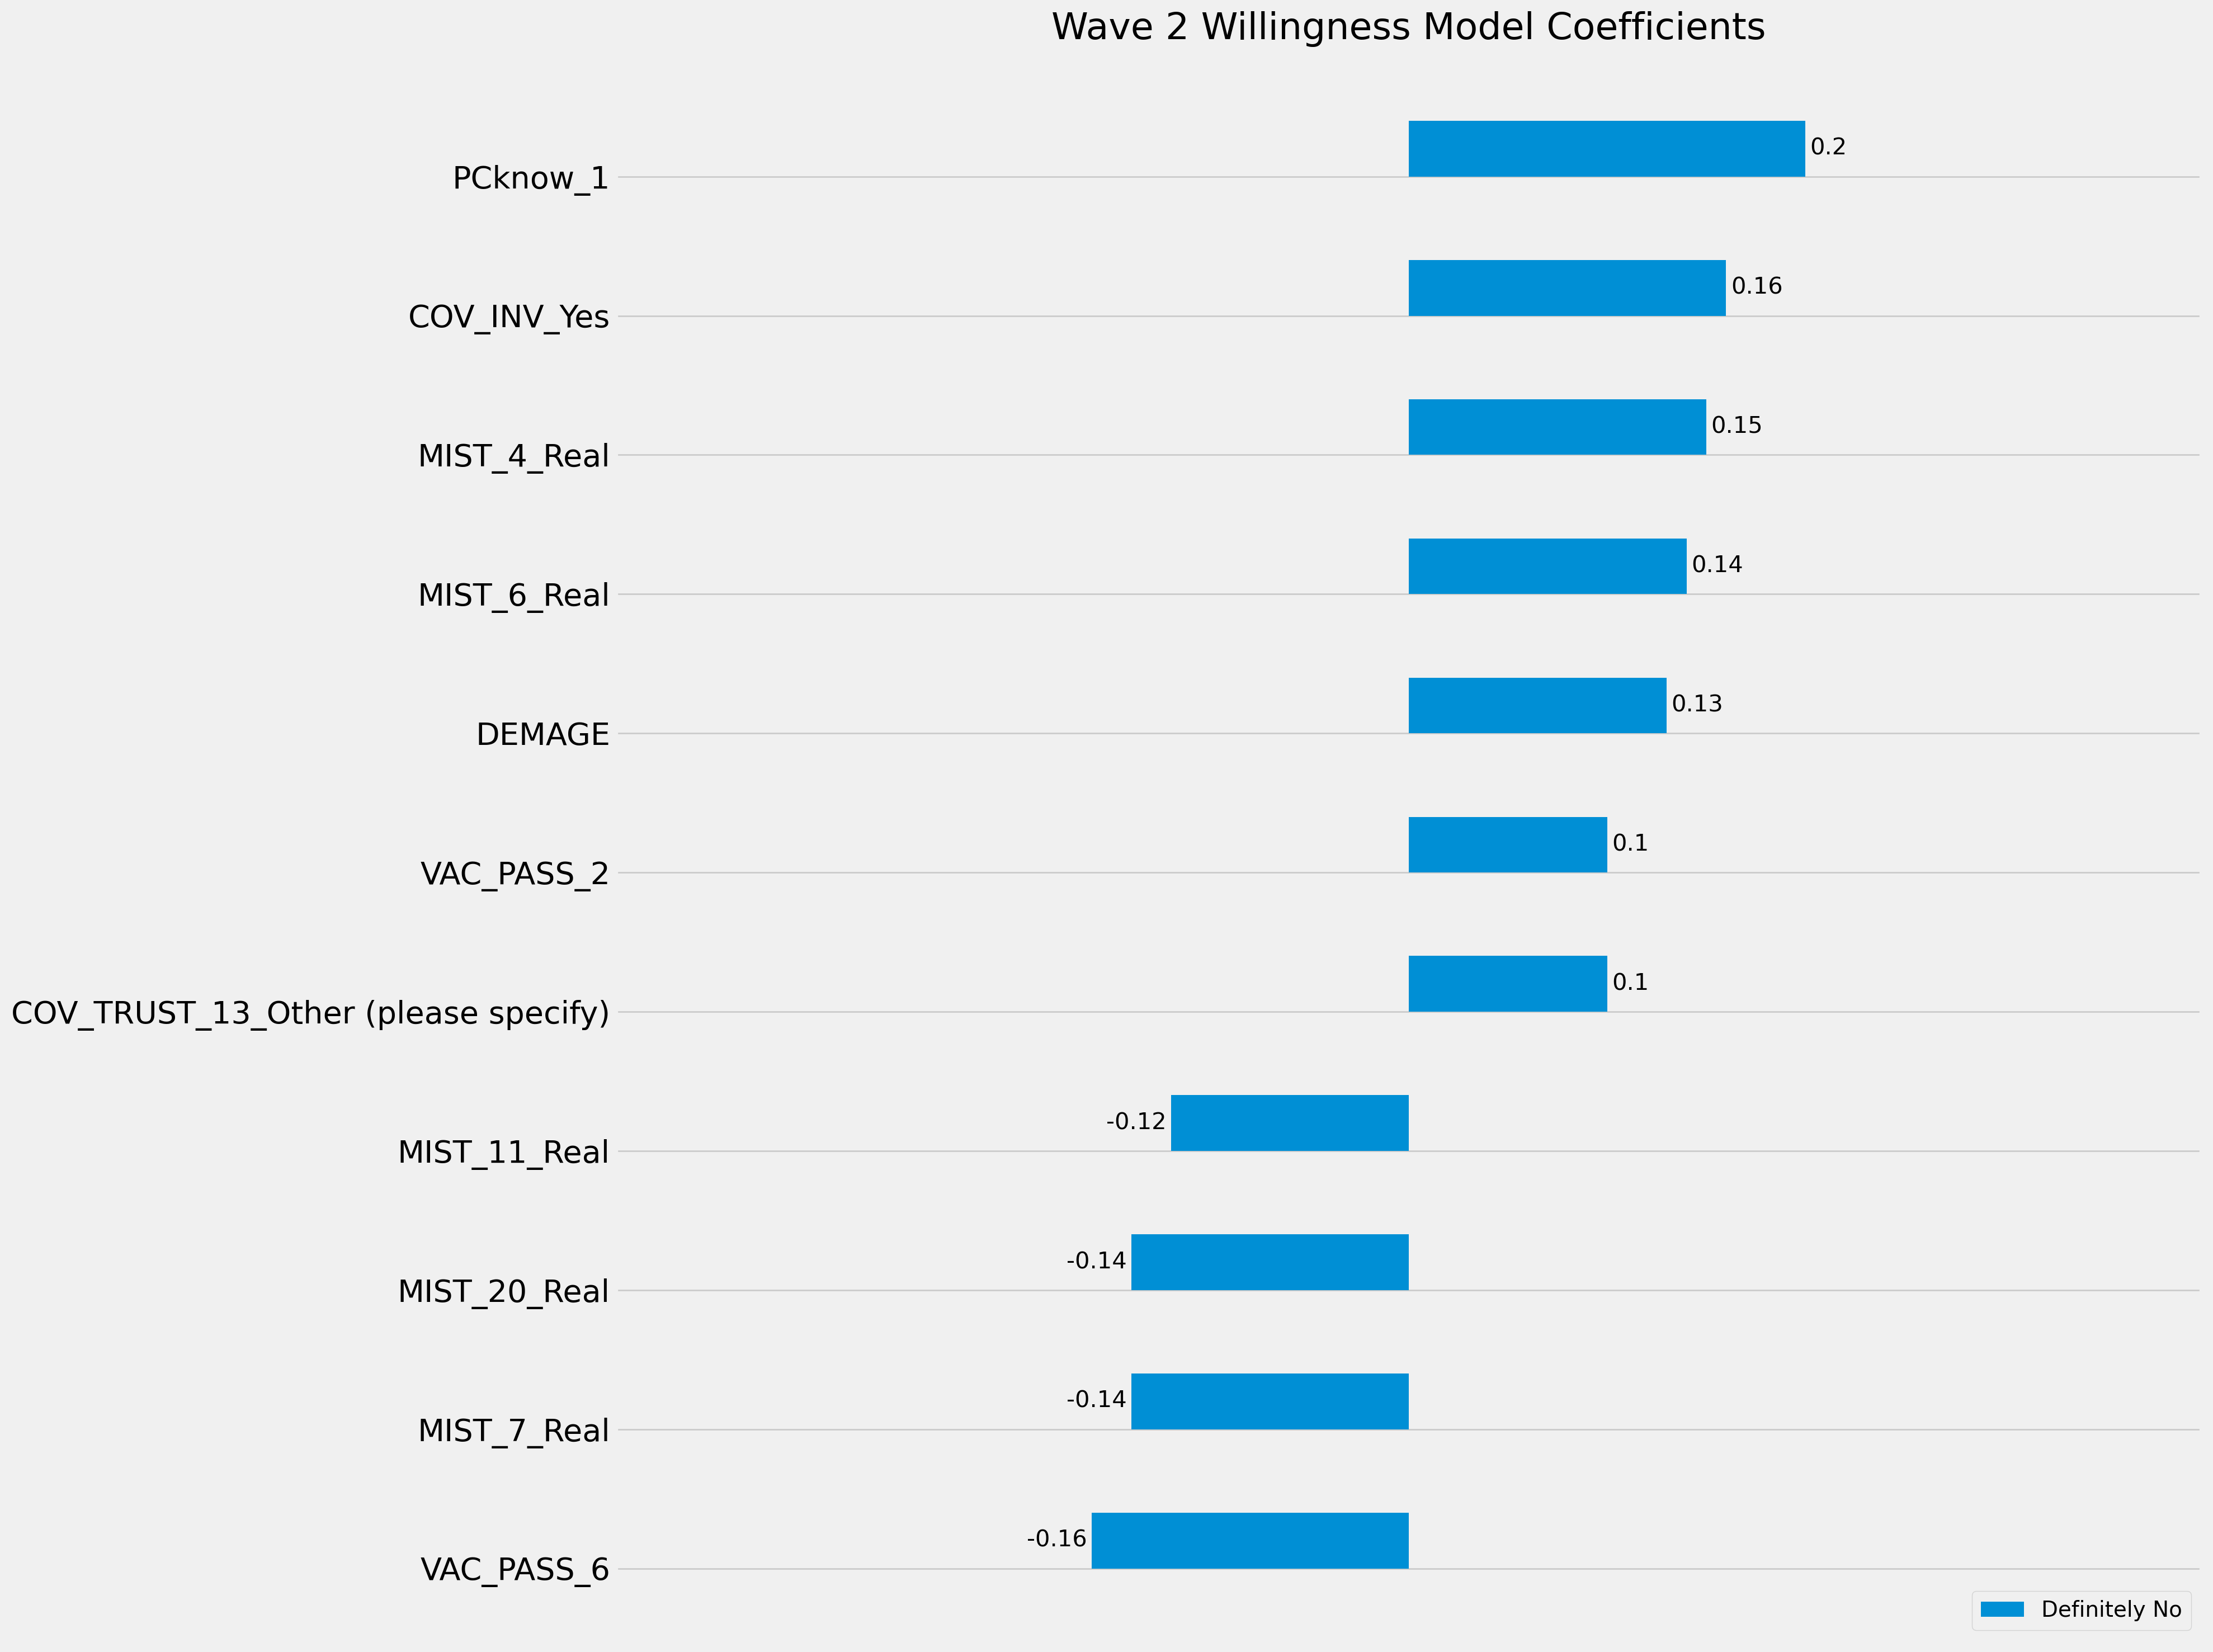

In [32]:
x = np.arange(len(labels))
width = 0.4


fig, ax = plt.subplots(figsize=(20, 15))
rects2 = ax.barh(x + width/2, value_4, width, label='Class 4')

ax.bar_label(rects2, padding=3, fontsize=15)
ax.set_yticks(x, labels, fontsize=20)
ax.set_xticks([])
ax.set_xlim(-0.4, 0.4)
ax.legend(labels=['Definitely No'], loc='lower right')
ax.set_title('Wave 2 Willingness Model Coefficients', fontsize=24)

fig.tight_layout()

plt.show()

In [33]:
# Full coefficient plotting for classes 1 and 4.
# labels = list(Xtr_final.columns)
# value_1 = list(reclog.coef_[0])
# value_4 = list(reclog.coef_[3])

# x = np.arange(len(labels))
# width = 0.4

# fig, ax = plt.subplots(figsize=(20, 30))
# rects1 = ax.barh(x - width/2, value_1, width, label='Class 1')
# rects2 = ax.barh(x + width/2, value_4, width, label='Class 4')

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.set_yticks(x, labels, fontsize=10)
# ax.legend()

# fig.tight_layout()

# plt.show()

In [34]:
print("\n------------------------------------\n"*20)


------------------------------------

------------------------------------

------------------------------------

------------------------------------

------------------------------------

------------------------------------

------------------------------------

------------------------------------

------------------------------------

------------------------------------

------------------------------------

------------------------------------

------------------------------------

------------------------------------

------------------------------------

------------------------------------

------------------------------------

------------------------------------

------------------------------------

------------------------------------



 <span style="color:red">**Section 3** - Binary class modelling on Uptake data

The final modelling stage aims to predict actual vaccine uptake, using a model similar to that used to predict intention above. In addition to the features used to predict vaccine intention/willingness as used above, the model will include predicted willingness itself as a predictor of uptake.

The modelling will therefore take place in two stages:
- Using the intention model above to predict willingness on the total dataset.
- Splitting the dataset into train/test
- Preprocessing the data and using the initial feature set + predictions as predictors of vaccine uptake

In [35]:
# Importing and preparing data for uptake analysis

In [36]:
w2_uptake = pd.read_csv("C:/Users/laure/OneDrive/Documents/Personal Admin Files/Stats or Career Stuff/General Assembly/Course Notes/Capstone Folder/Cleaned_data/wave_2_vaccine_uptake_data_dropped.csv")
w2_uptake.drop('Unnamed: 0', axis=1, inplace=True)
w2_uptake['COV_INV_Yes'] = 1

In [37]:
w2_uptake.shape

(5810, 108)

**Section 3a** - Generating intention predictions

In [38]:
# Generating intention predictions using above intention model for use as a predictor variable
# Creating intention prediction variables
X_uptake = w2_uptake[["COV_KNOWL_1",
"COV_KNOWL_2",
"COV_KNOWL_3",
"COV_KNOWL_4",
"COV_KNOWL_5",
"COV_KNOWL_6",
"COV_KNOWL_7",
"ANX_1",
"ANX_2",
"ANX_3",
"ANX_4",
"ANX_5",
"ANX_6",
"DEMAGE",
"DREAD",
"VAC_DEC",
"VAC_PASS_1",
"VAC_PASS_2",
"VAC_PASS_3",
"VAC_PASS_4",
"VAC_PASS_5",
"VAC_PASS_6",
"VAC_PASS_7",
"MIST_1_Real",
"MIST_2_Real",
"MIST_3_Real",
"MIST_4_Real",
"MIST_5_Real",
"MIST_6_Real",
"MIST_7_Real",
"MIST_8_Real",
"MIST_9_Real",
"MIST_10_Real",
"MIST_11_Real",
"MIST_12_Real",
"MIST_13_Real",
"MIST_14_Real",
"MIST_15_Real",
"MIST_16_Real",
"MIST_17_Real",
"MIST_18_Real",
"MIST_19_Real",
"MIST_20_Real",
"DEMREG_East of England",
"DEMREG_Greater London",
"DEMREG_North East",
"DEMREG_North West",
"DEMREG_Northern Ireland",
"DEMREG_Scotland",
"DEMREG_South East",
"DEMREG_South West",
"DEMREG_Wales",
"DEMREG_West Midlands",
"DEMREG_Yorkshire and The Humber",
"DEMSEX_Male",
"DEMEDU_2+ A levels or equivalents",
"DEMEDU_5+ GCSE, O-levels, 1 A level, or equivalents",
"DEMEDU_Apprenticeship",
"DEMEDU_No academic qualifications",
"DEMEDU_Other",
"DEMEDU_Undergraduate or postgraduate degree",
"DEMWRK_Retired",
"DEMWRK_Student",
"DEMWRK_Unable to work",
"DEMWRK_Unemployed",
"DEMWRK_Working full-time",
"DEMWRK_Working part-time",
"DEMREL_Christian",
"DEMREL_Muslim",
"DEMREL_Other",
"DEMINC_Under £15,000",
"DEMINC_£15,000 to £24,999",
"DEMINC_£25,000 to £34,999",
"DEMINC_£35,000 to £44,999",
"DEMINC_£45,000 to £54,999",
"DEMINC_£55,000 to £64,999",
"DEMINC_£65,000 to £99,999",
"COV_INV_Yes",
"DEMNHS_Yes",
"COV_SHIELD_Yes",
"Q71_Green Party",
"Q71_Labour",
"Q71_Liberal Democrat",
"Q71_Local independent",
"Q71_Other/Not eligible",
"Q71_Reform Party ",
"Q71_SNP",
"COV_TRUST_1_National television",
"COV_TRUST_2_Satellite / international television channels",
"COV_TRUST_3_Radio",
"COV_TRUST_4_Newspapers",
"COV_TRUST_5_Social media (Facebook, Twitter, etc)",
"COV_TRUST_6_National public health authorities (such as the NHS or Public Health England / Wales)",
"COV_TRUST_7_Healthcare workers",
"COV_TRUST_8_International health authorities (such as The World Health Organization)",
"COV_TRUST_9_Government websites",
"COV_TRUST_10_The internet or search engines",
"COV_TRUST_11_Family and friends",
"COV_TRUST_12_Work, school, or college",
"COV_TRUST_13_Other (please specify)"]]

# Scaling uptake data according to intention model scaled specification
Xupt_std = scaler.transform(X_uptake)

#Applying PCA transformations
emotion_vars = ['DREAD', 'ANX_1', 'ANX_2', 'ANX_3', 'ANX_4', 'ANX_5',
     'ANX_6']

emo_transform = pd.DataFrame(pca_emomulti.transform(X_uptake[emotion_vars]),
                             columns=[f'PCemo_{i+1}' for i in range(pca_emomulti.n_components_)])

mergedXupt = pd.merge(pd.DataFrame(Xupt_std, columns=X_uptake.columns), emo_transform, left_index=True, right_index=True)
mergedXupt.drop(emotion_vars, axis=1, inplace=True)

knowledge_vars = ['COV_KNOWL_1', 'COV_KNOWL_2',
     'COV_KNOWL_3', 'COV_KNOWL_4', 'COV_KNOWL_5', 'COV_KNOWL_6',
     'COV_KNOWL_7']

know_transform = pd.DataFrame(pca_knomulti.transform(X_uptake[knowledge_vars]),
                             columns=[f'PCknow_{i+1}' for i in range(pca_knomulti.n_components_)])

Xupt_final = pd.merge(mergedXupt, know_transform, left_index=True, right_index=True)
Xupt_final.drop(knowledge_vars, axis=1, inplace=True)

# Generating predictions
predictions = reclog.predict(Xupt_final)

# Applying predictions to uptake dataset
w2_uptake['intent_predictions'] = predictions

 <span style="color:red"> **Section 3b** - Uptake modelling

The uptake modelling follows the same process as per previous intention modelling:
- A run of initial base estimators
- Optimisation of preferred model
- Analysis of results

In [39]:
# Uptake modelling
# Setting uptake target
y = w2_uptake['uptaketarget']
y.value_counts(normalize=True).max() # Generating base model accuracy

0.9433734939759036

In [40]:
w2_uptake.shape

(5810, 109)

In [41]:
# Assigning predictor variables
X = w2_uptake[["COV_KNOWL_1",
"COV_KNOWL_2",
"COV_KNOWL_3",
"COV_KNOWL_4",
"COV_KNOWL_5",
"COV_KNOWL_6",
"COV_KNOWL_7",
"ANX_1",
"ANX_2",
"ANX_3",
"ANX_4",
"ANX_5",
"ANX_6",
"DEMAGE",
"DREAD",
"VAC_DEC",
"VAC_PASS_1",
"VAC_PASS_2",
"VAC_PASS_3",
"VAC_PASS_4",
"VAC_PASS_5",
"VAC_PASS_6",
"VAC_PASS_7",
"MIST_1_Real",
"MIST_2_Real",
"MIST_3_Real",
"MIST_4_Real",
"MIST_5_Real",
"MIST_6_Real",
"MIST_7_Real",
"MIST_8_Real",
"MIST_9_Real",
"MIST_10_Real",
"MIST_11_Real",
"MIST_12_Real",
"MIST_13_Real",
"MIST_14_Real",
"MIST_15_Real",
"MIST_16_Real",
"MIST_17_Real",
"MIST_18_Real",
"MIST_19_Real",
"MIST_20_Real",
"DEMREG_East of England",
"DEMREG_Greater London",
"DEMREG_North East",
"DEMREG_North West",
"DEMREG_Northern Ireland",
"DEMREG_Scotland",
"DEMREG_South East",
"DEMREG_South West",
"DEMREG_Wales",
"DEMREG_West Midlands",
"DEMREG_Yorkshire and The Humber",
"DEMSEX_Male",
"DEMEDU_2+ A levels or equivalents",
"DEMEDU_5+ GCSE, O-levels, 1 A level, or equivalents",
"DEMEDU_Apprenticeship",
"DEMEDU_No academic qualifications",
"DEMEDU_Other",
"DEMEDU_Undergraduate or postgraduate degree",
"DEMWRK_Retired",
"DEMWRK_Student",
"DEMWRK_Unable to work",
"DEMWRK_Unemployed",
"DEMWRK_Working full-time",
"DEMWRK_Working part-time",
"DEMREL_Christian",
"DEMREL_Muslim",
"DEMREL_Other",
"DEMINC_Under £15,000",
"DEMINC_£15,000 to £24,999",
"DEMINC_£25,000 to £34,999",
"DEMINC_£35,000 to £44,999",
"DEMINC_£45,000 to £54,999",
"DEMINC_£55,000 to £64,999",
"DEMINC_£65,000 to £99,999",
"DEMNHS_Yes",
"COV_SHIELD_Yes",
"Q71_Green Party",
"Q71_Labour",
"Q71_Liberal Democrat",
"Q71_Local independent",
"Q71_Other/Not eligible",
"Q71_Reform Party ",
"Q71_SNP",
"COV_TRUST_1_National television",
"COV_TRUST_2_Satellite / international television channels",
"COV_TRUST_3_Radio",
"COV_TRUST_4_Newspapers",
"COV_TRUST_5_Social media (Facebook, Twitter, etc)",
"COV_TRUST_6_National public health authorities (such as the NHS or Public Health England / Wales)",
"COV_TRUST_7_Healthcare workers",
"COV_TRUST_8_International health authorities (such as The World Health Organization)",
"COV_TRUST_9_Government websites",
"COV_TRUST_10_The internet or search engines",
"COV_TRUST_11_Family and friends",
"COV_TRUST_12_Work, school, or college",
"COV_TRUST_13_Other (please specify)",
'intent_predictions']]

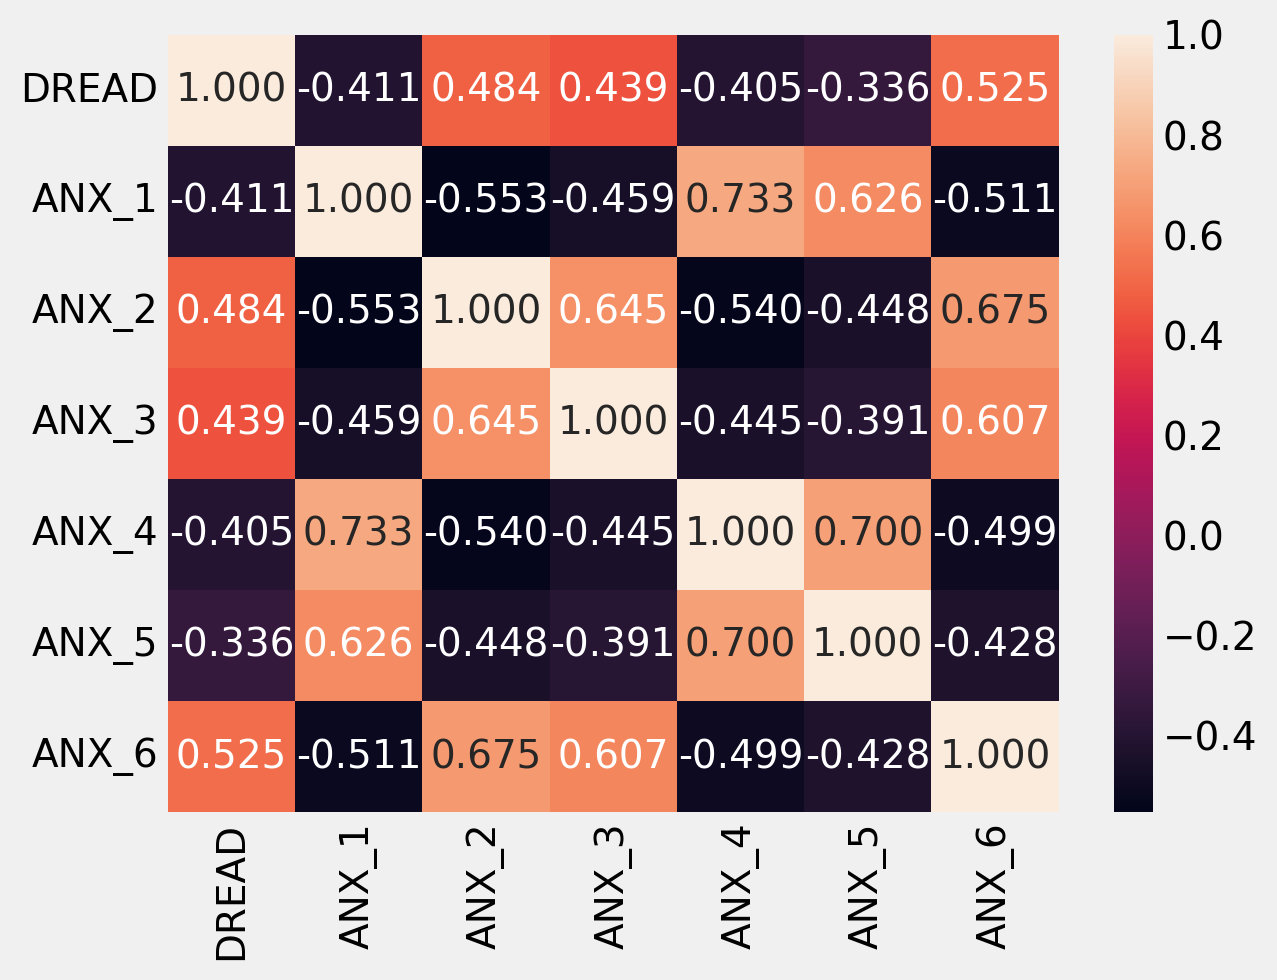

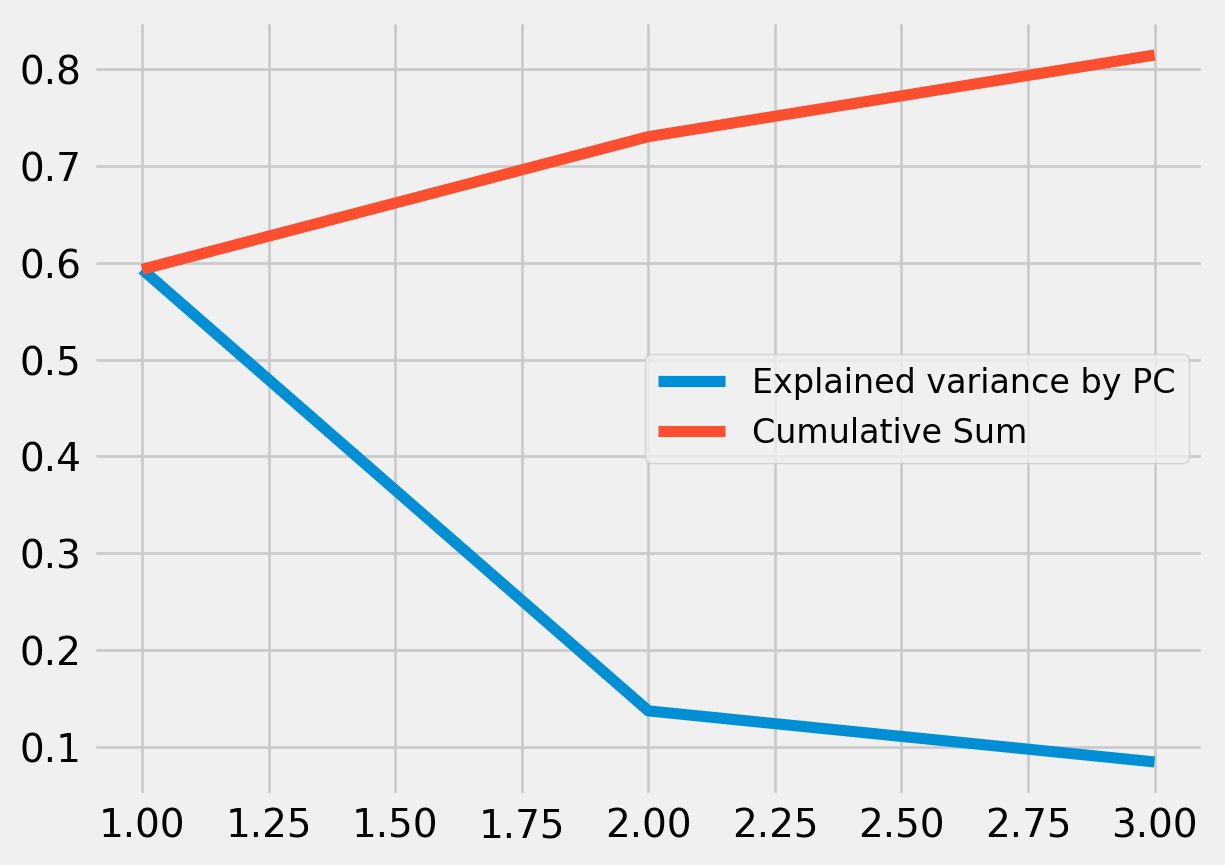

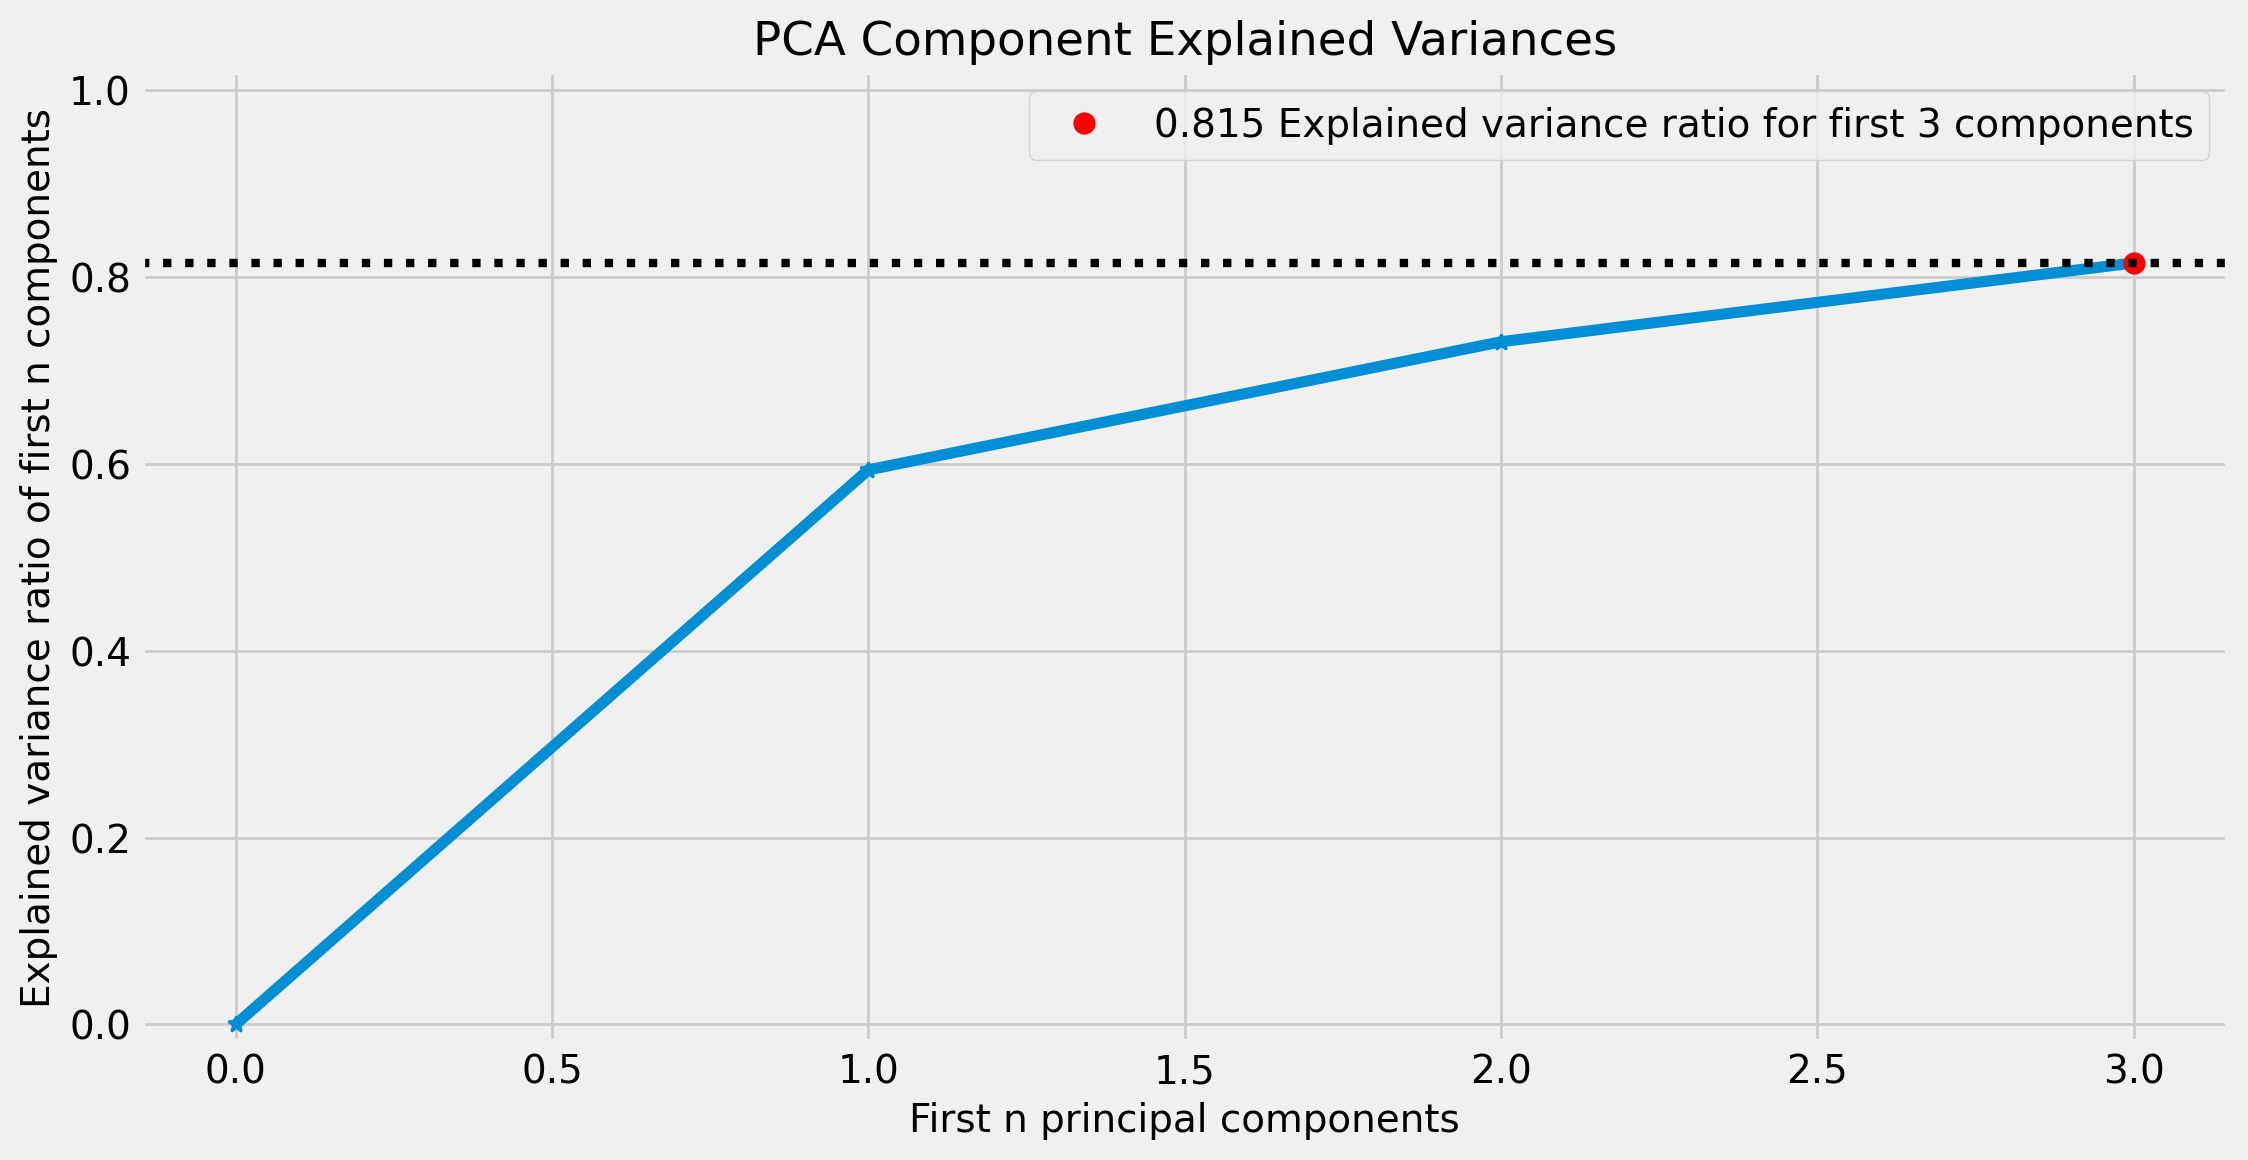

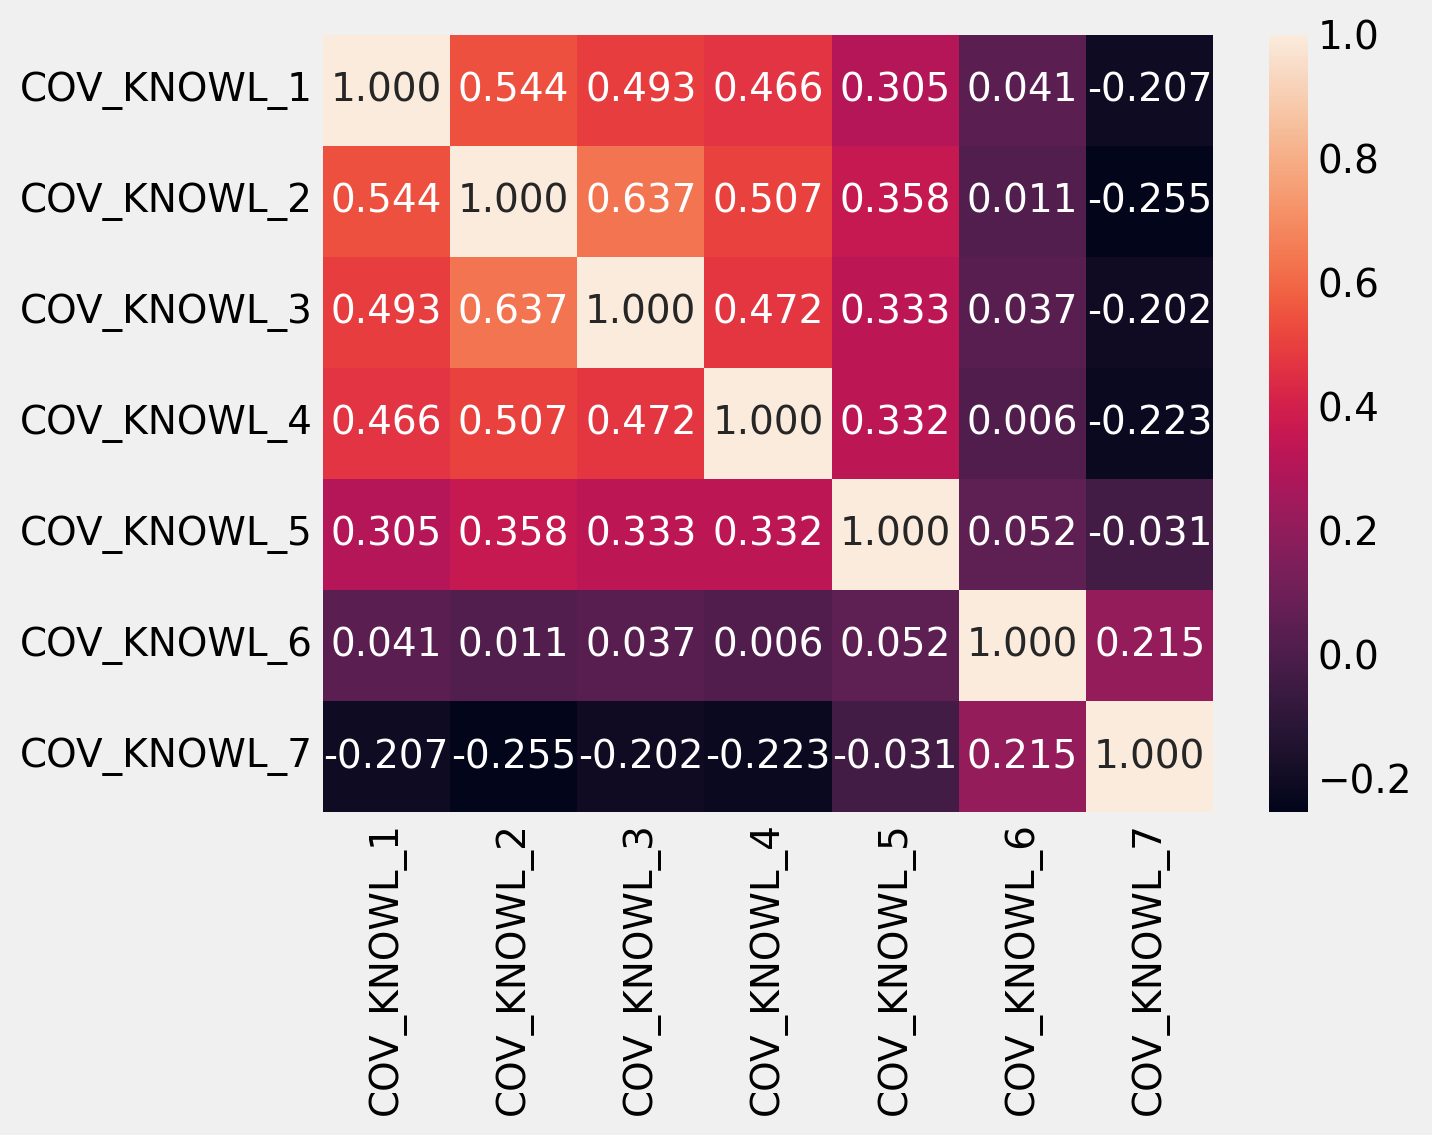

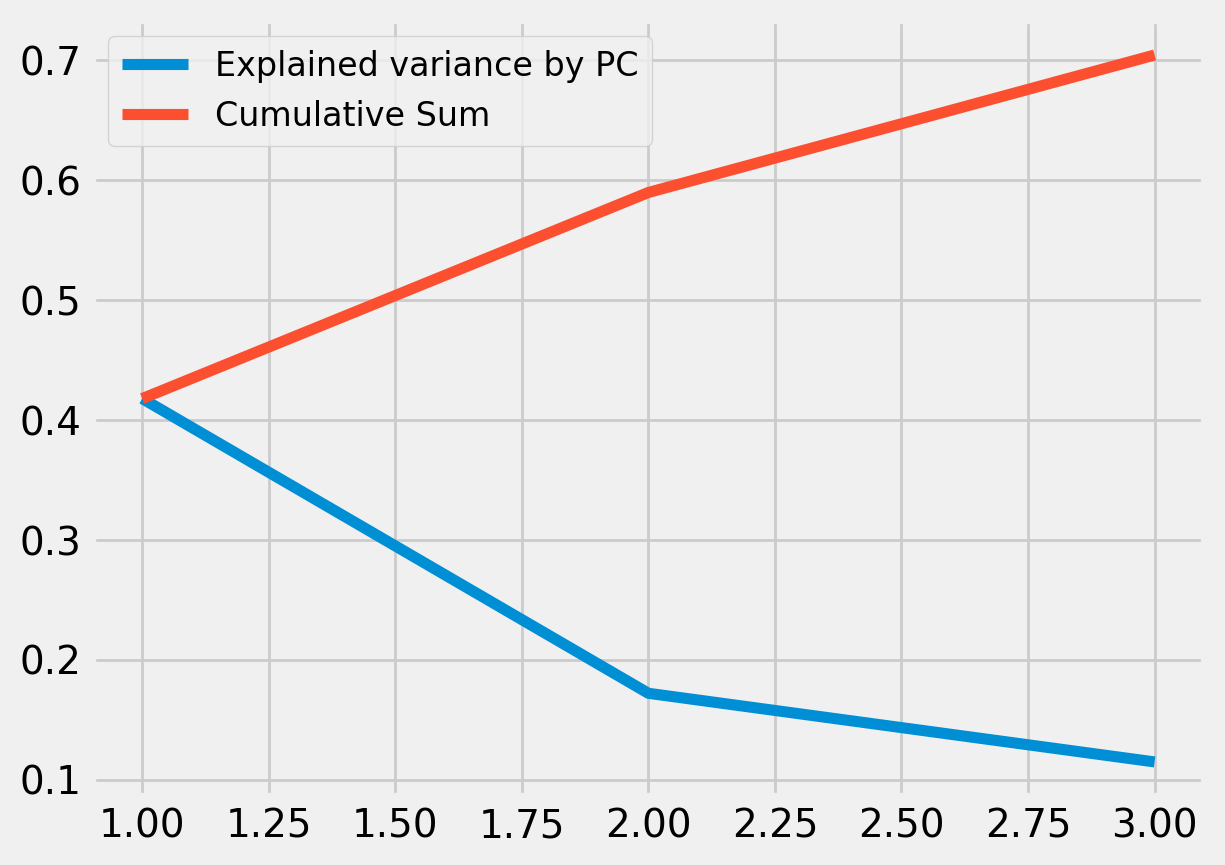

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


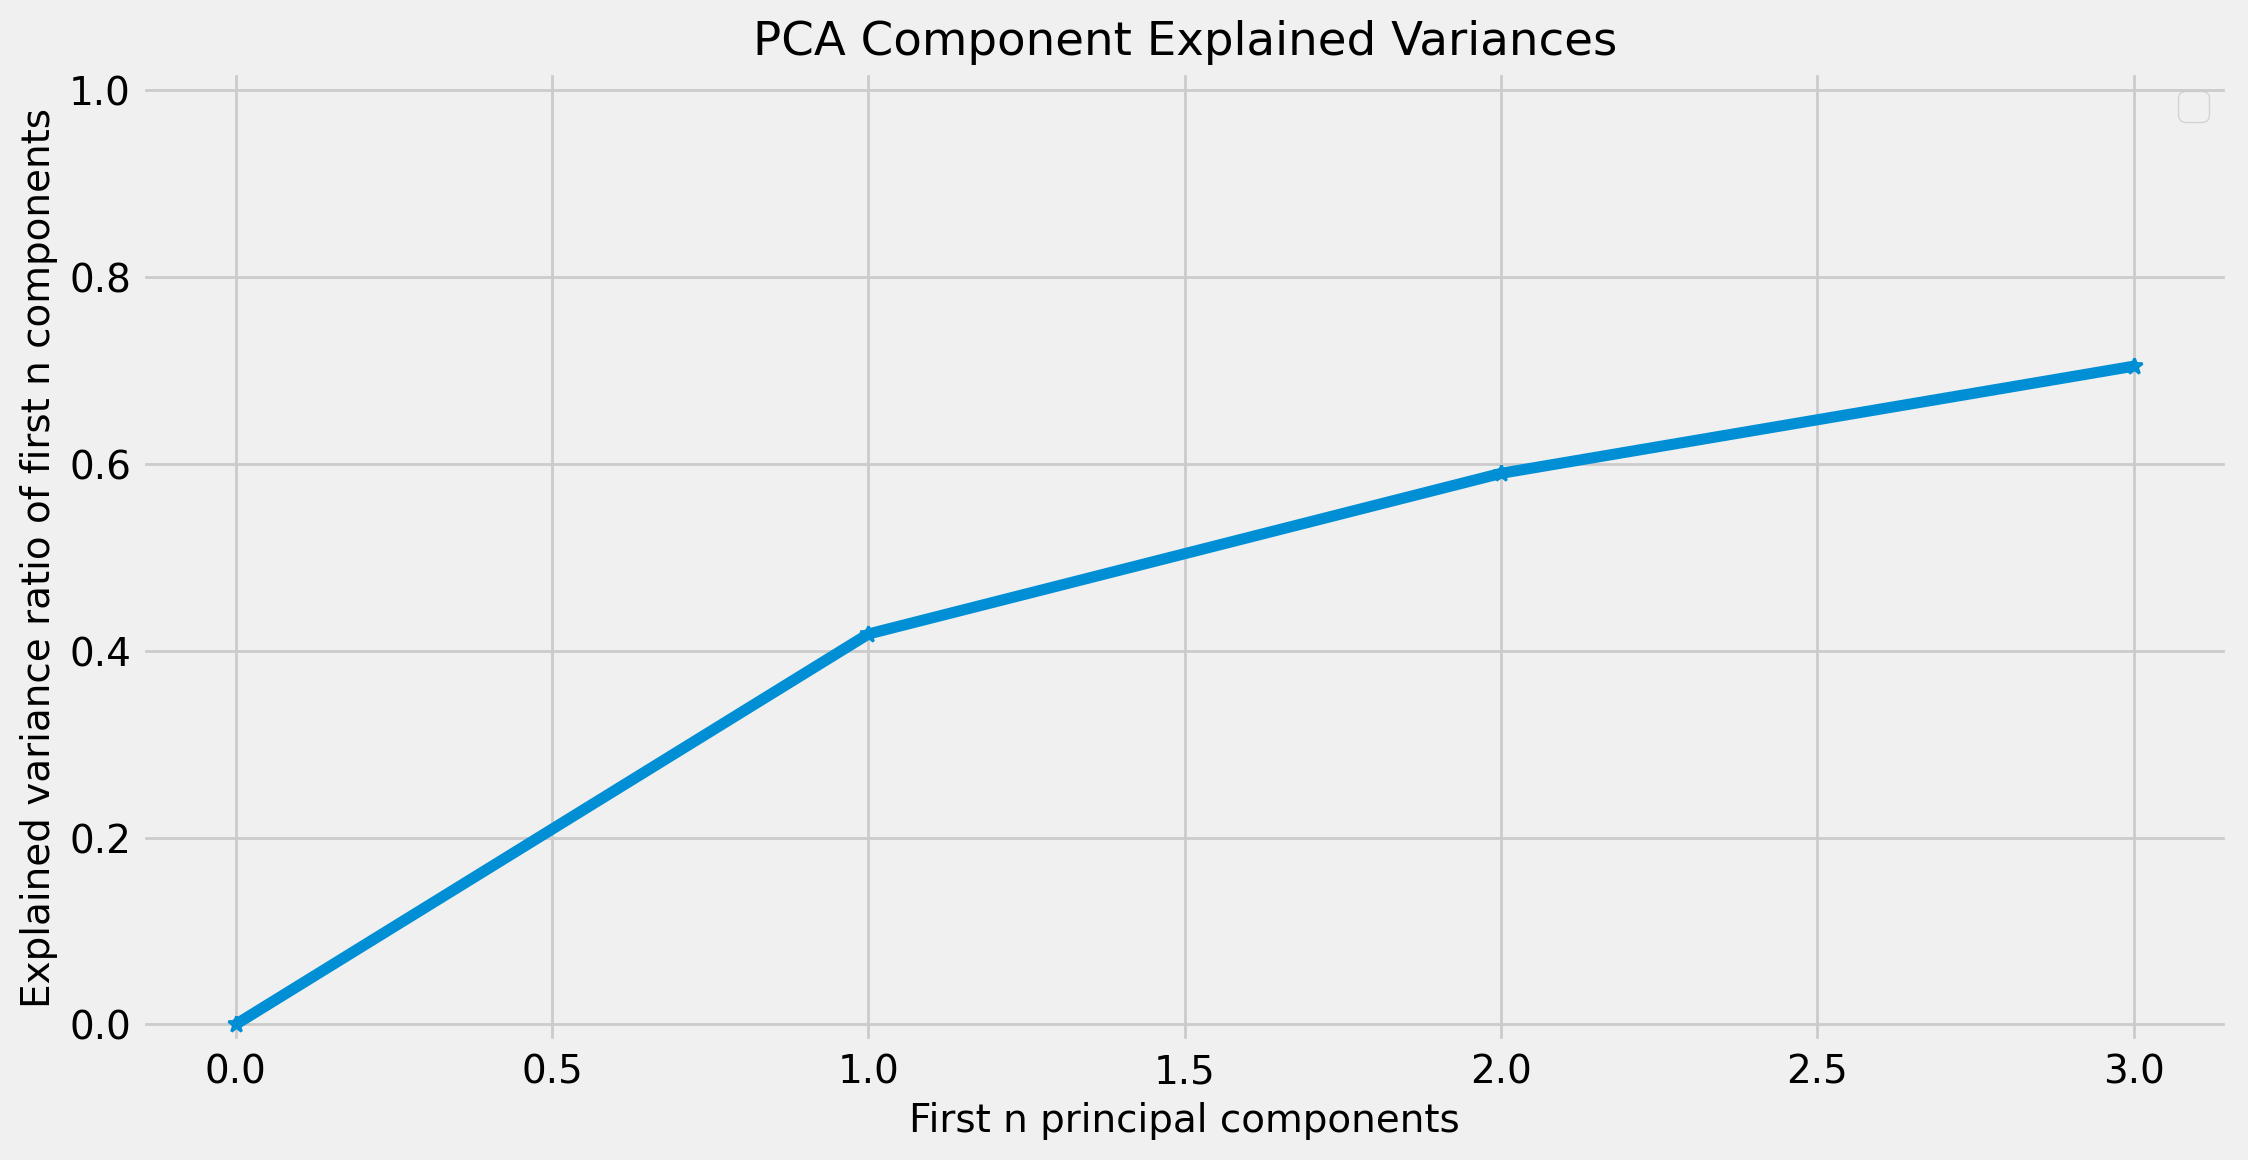

In [42]:
# RUNNING PREPROCESSING
# Train test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=3)

# Scaling
scaler = StandardScaler()
Xstd_train = scaler.fit_transform(X_train)
Xstd_test = scaler.transform(X_test)

# Applying PCA to emotion Vars
emotion_vars = ['DREAD', 'ANX_1', 'ANX_2', 'ANX_3', 'ANX_4', 'ANX_5',
     'ANX_6']

X[emotion_vars].corr()
sns.heatmap(X[emotion_vars].corr(), annot=True, fmt='.3f')
plt.show()

X_traindf = pd.DataFrame(Xstd_train, columns=list(X.columns))
X_testdf = pd.DataFrame(Xstd_test, columns=list(X.columns))

pca_emomulti = PCA(n_components=3)
pca_emomulti.fit(X_traindf[emotion_vars])

plt.plot(range(1, pca_emomulti.n_components_+1), pca_emomulti.explained_variance_ratio_, label="Explained variance by PC")
plt.plot(range(1, pca_emomulti.n_components_+1), pca_emomulti.explained_variance_ratio_.cumsum(), label="Cumulative Sum")
plt.legend(fontsize=12)
plt.show()

plot_pca_component_variance(pca_emomulti, target_explained_variance=0.75, figsize=(12, 6))
plt.show()

pca_emomulti.explained_variance_ratio_.cumsum()

emo_tran_train = pd.DataFrame(pca_emomulti.transform(X_traindf[emotion_vars]),
                             columns=[f'PCemo_{i+1}' for i in range(pca_emomulti.n_components_)])
emo_tran_test = pd.DataFrame(pca_emomulti.transform(X_testdf[emotion_vars]),
                             columns=[f'PCemo_{i+1}' for i in range(pca_emomulti.n_components_)])

merged_train = pd.merge(X_traindf, emo_tran_train, left_index=True, right_index=True)
merged_train.drop(emotion_vars, axis=1, inplace=True)
merged_test = pd.merge(X_testdf, emo_tran_test, left_index=True, right_index=True)
merged_test.drop(emotion_vars, axis=1, inplace=True)



# Applying PCA to knowledge Vars
knowledge_vars = ['COV_KNOWL_1', 'COV_KNOWL_2',
     'COV_KNOWL_3', 'COV_KNOWL_4', 'COV_KNOWL_5', 'COV_KNOWL_6',
     'COV_KNOWL_7']

X[knowledge_vars].corr()
sns.heatmap(X[knowledge_vars].corr(), annot=True, fmt='.3f')
plt.show()

pca_knomulti = PCA(n_components=3)
pca_knomulti.fit(merged_train[knowledge_vars])

plt.plot(range(1, pca_knomulti.n_components_+1), pca_knomulti.explained_variance_ratio_, label="Explained variance by PC")
plt.plot(range(1, pca_knomulti.n_components_+1), pca_knomulti.explained_variance_ratio_.cumsum(), label="Cumulative Sum")
plt.legend(fontsize=12)
plt.show()

plot_pca_component_variance(pca_knomulti, target_explained_variance=0.75, figsize=(12, 6))
plt.show()

pca_knomulti.explained_variance_ratio_.cumsum()

know_tran_train = pd.DataFrame(pca_knomulti.transform(merged_train[knowledge_vars]),
                             columns=[f'PCknow_{i+1}' for i in range(pca_knomulti.n_components_)])
know_tran_test = pd.DataFrame(pca_knomulti.transform(merged_test[knowledge_vars]),
                             columns=[f'PCknow_{i+1}' for i in range(pca_knomulti.n_components_)])

Xtr_final = pd.merge(merged_train, know_tran_train, left_index=True, right_index=True)
Xtr_final.drop(knowledge_vars, axis=1, inplace=True)
Xte_final = pd.merge(merged_test, know_tran_test, left_index=True, right_index=True)
Xte_final.drop(knowledge_vars, axis=1, inplace=True)


# Applying SMOTE oversampling
over = SMOTE()
X_smote, y_smote = over.fit_resample(Xtr_final, y_train)

In [43]:
# Initialising score dictionary and running optimised estimators
scores = {
    'Model Name': [],
    'Train Accuracy': [],
    'Cross Validation Accuracy': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test Recall': [],
    'Test F1 Score': [],
    'Cross Validation ROC AUC': [],
    'Test ROC AUC Score': [],
    'Variance': [],
    'Bias': [],
    'Variance/bias': []
}

models = [KNeighborsClassifier(),
          LogisticRegression(),
          DecisionTreeClassifier(),
          RandomForestClassifier()]

for model in models:
    print(f'Model: {model}')
    model_run_binary(model, X_smote, Xte_final, y_smote, y_test)
    print()
    print('-----------------------')
    print()

Model: KNeighborsClassifier()
Training accuracy score: 0.8701254275940707
5-Fold Cross Val accuracy score: 0.8207525655644241
Test accuracy score: 0.6729776247848537

5-Fold Cross Val ROCAUC score: 0.9335266255725634
ROC_AUC_SCORE Test: 0.7886598650740987

[[ 52  14]
 [366 730]]

              precision    recall  f1-score   support

         0.0       0.12      0.79      0.21        66
         1.0       0.98      0.67      0.79      1096

    accuracy                           0.67      1162
   macro avg       0.55      0.73      0.50      1162
weighted avg       0.93      0.67      0.76      1162


-----------------------

Model: LogisticRegression()
Training accuracy score: 0.8452679589509692
5-Fold Cross Val accuracy score: 0.8383124287343214
Test accuracy score: 0.8132530120481928

5-Fold Cross Val ROCAUC score: 0.9008054565619033
ROC_AUC_SCORE Test: 0.8608714886087149

[[ 52  14]
 [203 893]]

              precision    recall  f1-score   support

         0.0       0.20      0.7

As per previous modelling, the priority focus for this model is to optimise predictions of the 'negative'/'have not had the vaccine' class (zero), as identifying this class is of greater importance for targeting any interventions/campaigns. Its important to note that the class 0 here do not necessarily represent vaccine 'rejectors', but instead are those who have been invited to take a vaccine and have not yet received it (either because they reject the vaccine, or because they have not yet gotten round to receiving the vaccine).

As per previous modelling, Decision tree and random forest classifiers tend to overfit on the train data and are worse at identifying the minority class of interest. KNN neighbours represents an improvement, but the Logistic classifier again performs best in terms of maximising minority class recall, while scoring well on ROC AUC. 

**Model optimisation**

Optimisation here focuses solely on gridsearch optimisation to target maximised recall - this methodology has yielded the best results previously. 

In [44]:
# LOGISTIC REGRESSION Grid search w.r.t Recall. 
# Note that the code has been commented to prevent accidentally running code requiring significant computational power

# log_params = {'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9, 0.99],
#               'C': np.logspace(-3, 0, 50)}

# log = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000)

# uptakelog = GridSearchCV(log, log_params, scoring='recall', n_jobs=2, cv=5, verbose=1)
# uptakelog.fit(X_smote, y_smote)
# uptake_opt = uptakelog.best_estimator_
# joblib.dump(uptake_opt, 'optimised_uptake.jlib')

In [45]:
uptake_final = joblib.load('optimised_uptake.jlib')

In [46]:
# Running uptake model
models = [uptake_final]

for model in models:
    print(f'Model: {model}')
    model_run_binary(model, X_smote, Xte_final, y_smote, y_test)
    print()
    print('-----------------------')
    print()

Model: LogisticRegression(C=0.001, l1_ratio=0.99, max_iter=1000, penalty='elasticnet',
                   solver='saga')
Training accuracy score: 0.7734321550741163
5-Fold Cross Val accuracy score: 0.7604332953249716
Test accuracy score: 0.7994836488812392

5-Fold Cross Val ROCAUC score: 0.8606642058744371
ROC_AUC_SCORE Test: 0.8638990267639902

[[ 48  18]
 [215 881]]

              precision    recall  f1-score   support

         0.0       0.18      0.73      0.29        66
         1.0       0.98      0.80      0.88      1096

    accuracy                           0.80      1162
   macro avg       0.58      0.77      0.59      1162
weighted avg       0.93      0.80      0.85      1162


-----------------------



C:\Users\laure\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


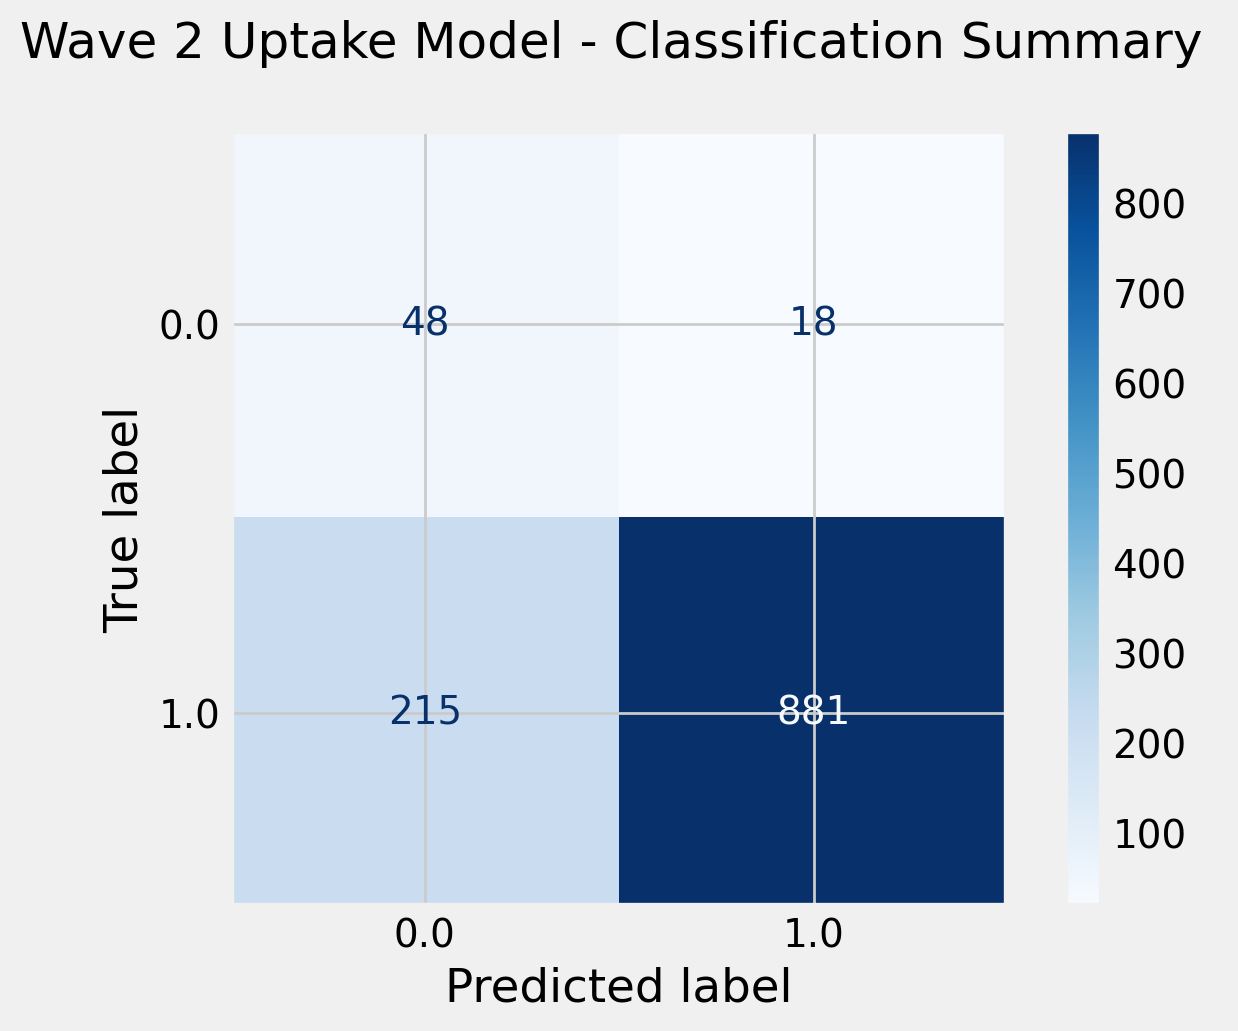

In [47]:
plot_confusion_matrix(uptake_final, Xte_final, y_test, cmap='Blues')
plt.title("Wave 2 Uptake Model - Classification Summary \n", fontsize=18)
plt.show()

**Section 3c - Deep dive into preferred models & coefficient analysis**

The Class 0 recall for the optimised model in fact appears to have fallen, suggesting the simple base estimator is better at identifying those who have been invited but not received the vaccine. Precision remains low, likely due to the unbalanced nature of the data - the model continues to find accurate prediction of the minority class difficult (although performs reasonably well in identifying the true values i.e. it identifies a high proportion of false negatives)

The ROC curve further suggests that the base model performs as well as the optimised model across a variety of thresholds.

Coefficient analysis again suggests that Age is a key factor in determining vaccine uptake - although given the age focused nature of the rollout, this is to be expected. In fact, most features are found to be unimportant, likely due to the overwhelming impact of the age variable. Intention predictions do appear to contribute to the predictive power of the model - higher intention scores (i.e. signifying reduced willingness to take the vaccine) does appear important in predicting whether or not an individual has received the vaccine.

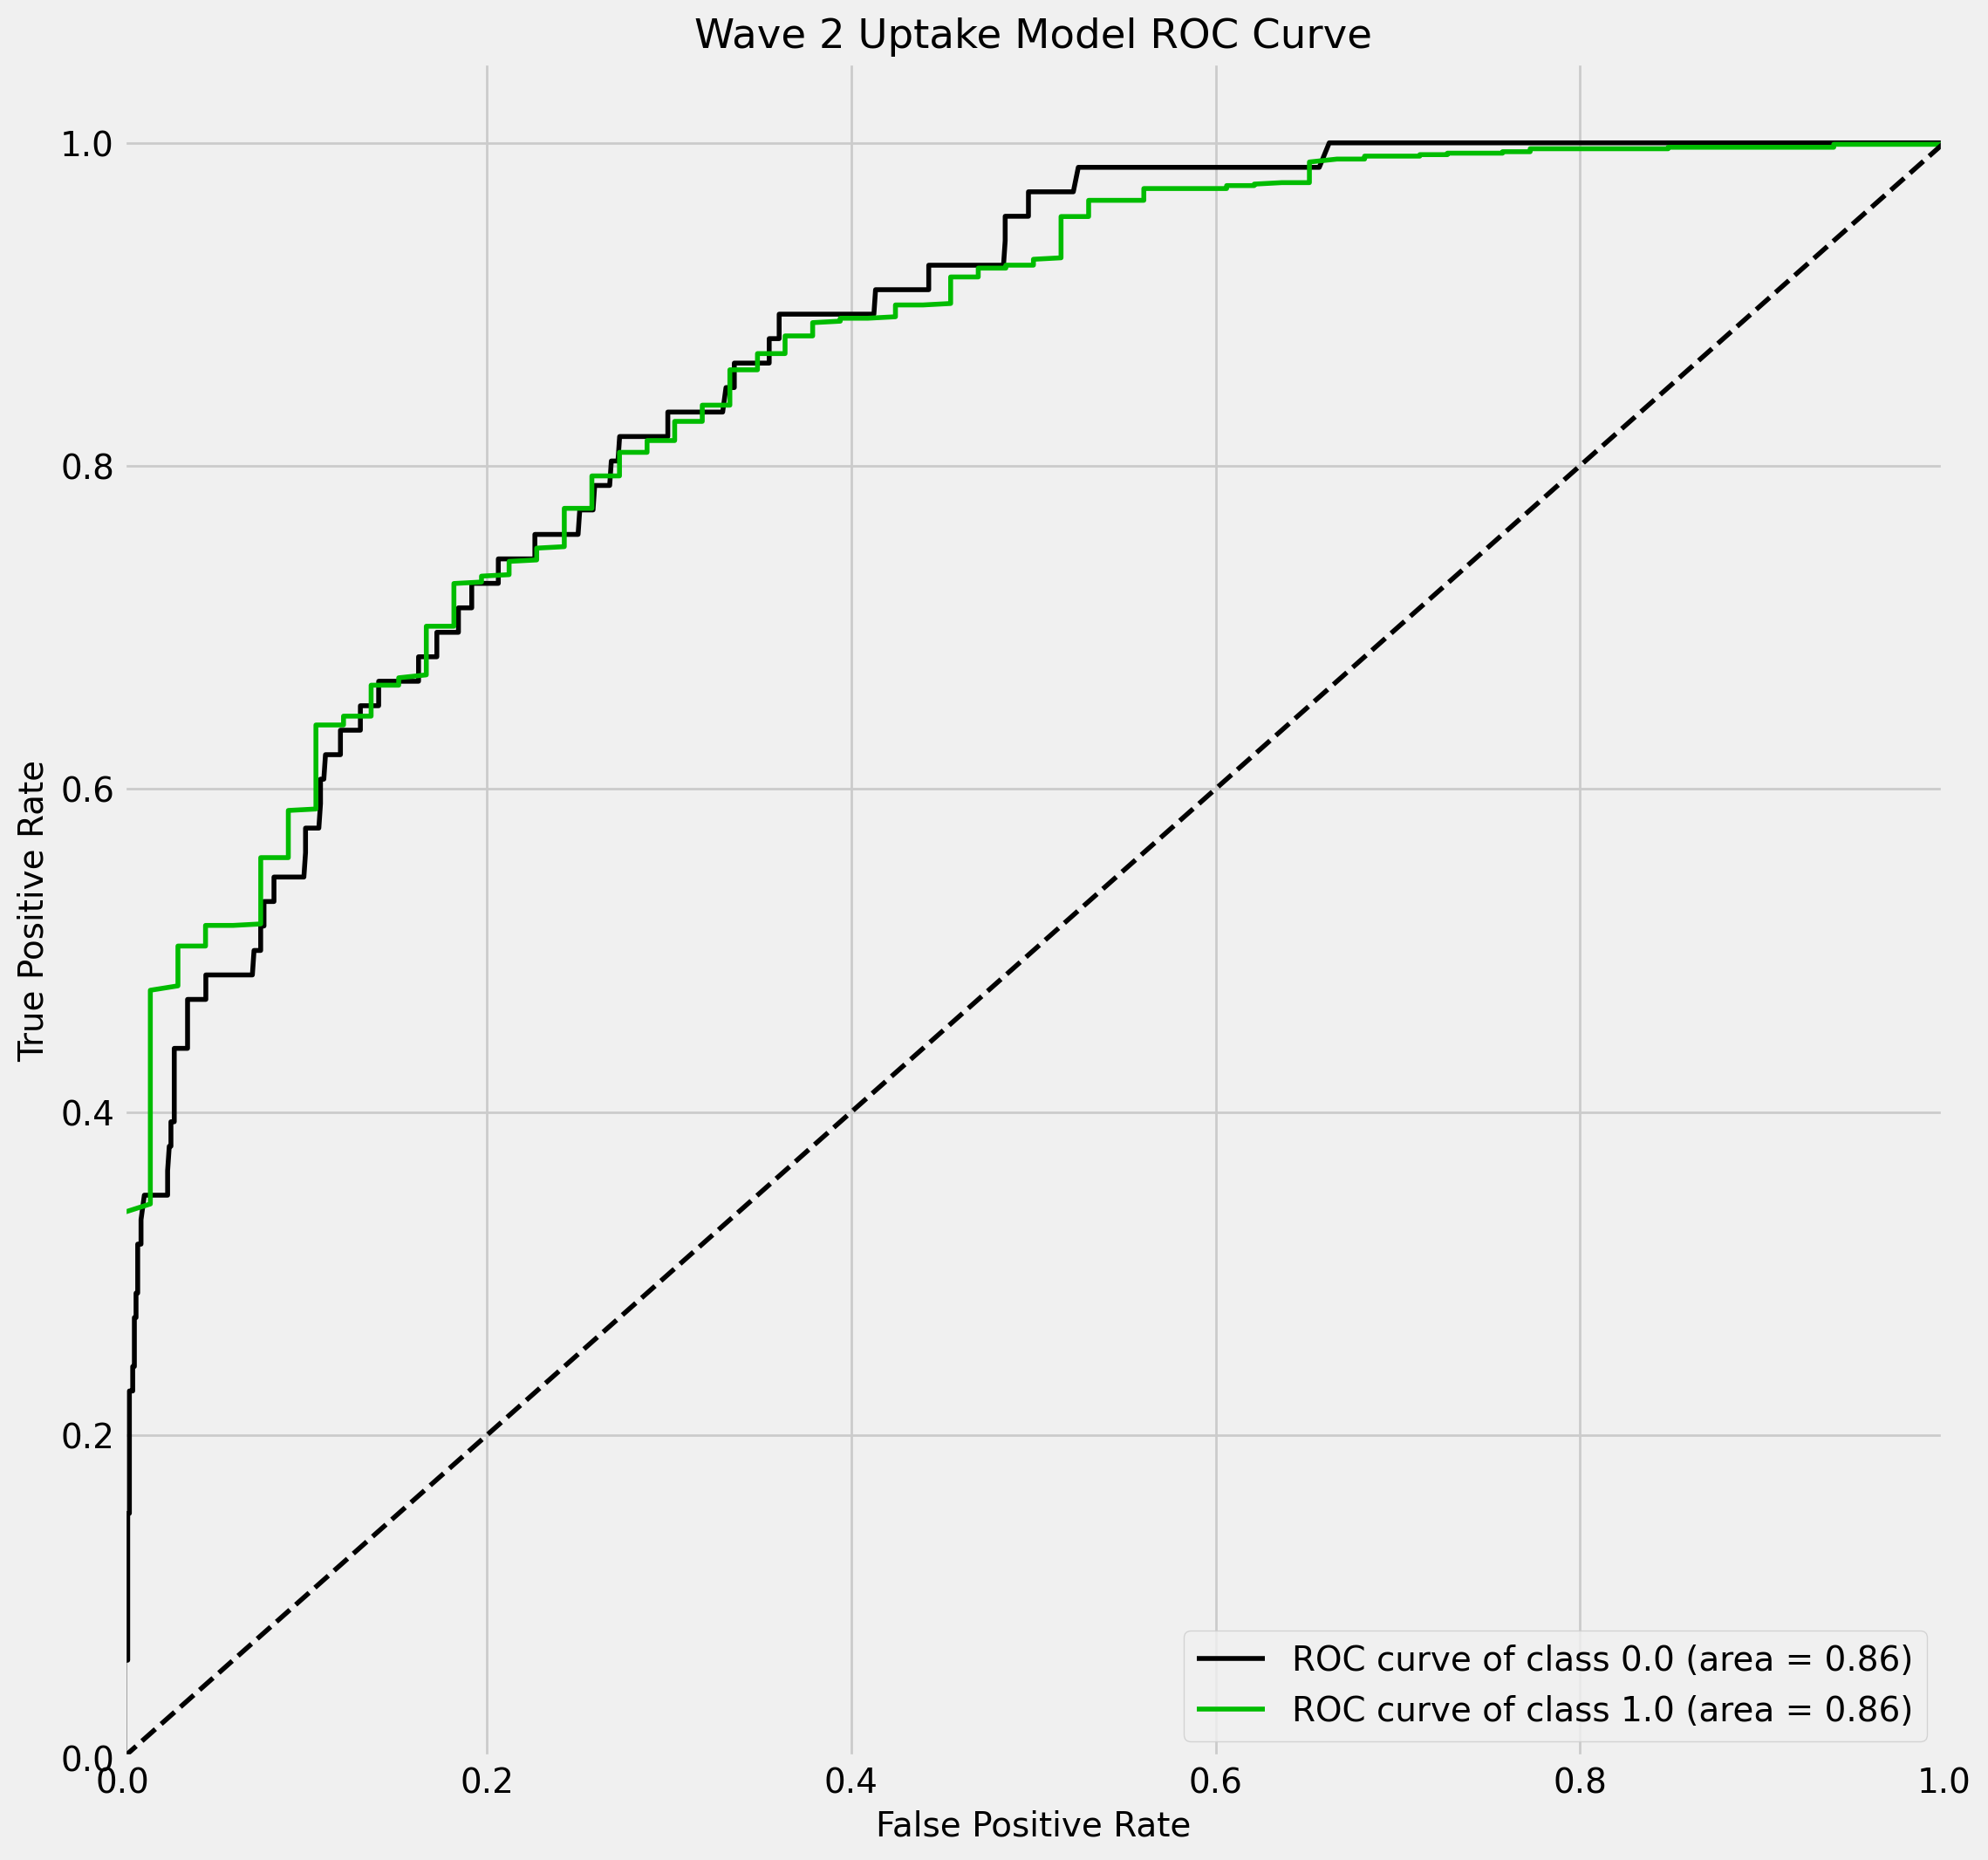

In [48]:
fig, ax = plt.subplots(figsize=(12, 12))
probas = uptake_final.predict_proba(Xte_final)
plot_roc(y_test, probas, title='Wave 2 Uptake Model ROC Curve', plot_micro=False, plot_macro=False, figsize=(10, 10), ax=ax)
plt.show()

In [49]:
# log = LogisticRegression()
# log.fit(X_smote, y_smote)

# fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
# probas = uptake_final.predict_proba(Xte_final)
# probas2 = log.predict_proba(Xte_final)
# plot_roc(y_test, probas, title='ROC Curve Optimised', plot_micro=False, plot_macro=False, figsize=(10, 10), ax=ax[0])
# plot_roc(y_test, probas2, title='ROC Curves base estimator', plot_micro=False, plot_macro=False, figsize=(10, 10), ax=ax[1])
# plt.show()

In [50]:
# BINARY COEFFICIENTS
coef = uptake_final.coef_
coef_exp = np.exp(uptake_final.coef_)
coef_data = pd.DataFrame(zip(Xtr_final.columns, list(coef)[0], list(coef_exp)[0]), columns=['Feature', 'Coefficients', 'A_coefs'])
coef_data.sort_values(by='A_coefs', ascending=False)

,Feature,Coefficients,A_coefs
0,DEMAGE,0.372497,1.451354
4,VAC_PASS_3,0.071898,1.074545
7,VAC_PASS_6,0.061675,1.063616
58,"DEMINC_£25,000 to £34,999",0.000000,1.000000
67,Q71_Liberal Democrat,0.000000,1.000000
...,...,...,...
28,MIST_20_Real,0.000000,1.000000
27,MIST_19_Real,0.000000,1.000000
91,PCknow_3,0.000000,1.000000
3,VAC_PASS_2,-0.192437,0.824946


In [51]:
coef_list = []

for i1, i2 in list(zip(Xtr_final.columns, uptake_final.coef_[0])):
    if round(i2, 2) != 0:
        item = (i1, i2)
        coef_list.append(item)

labels = []    
value_1 = []

for item in sorted(coef_list, key=lambda x: x[1]):
    label = item[0]
    value = round(item[1], 2)
    
    labels.append(label)
    value_1.append(value)

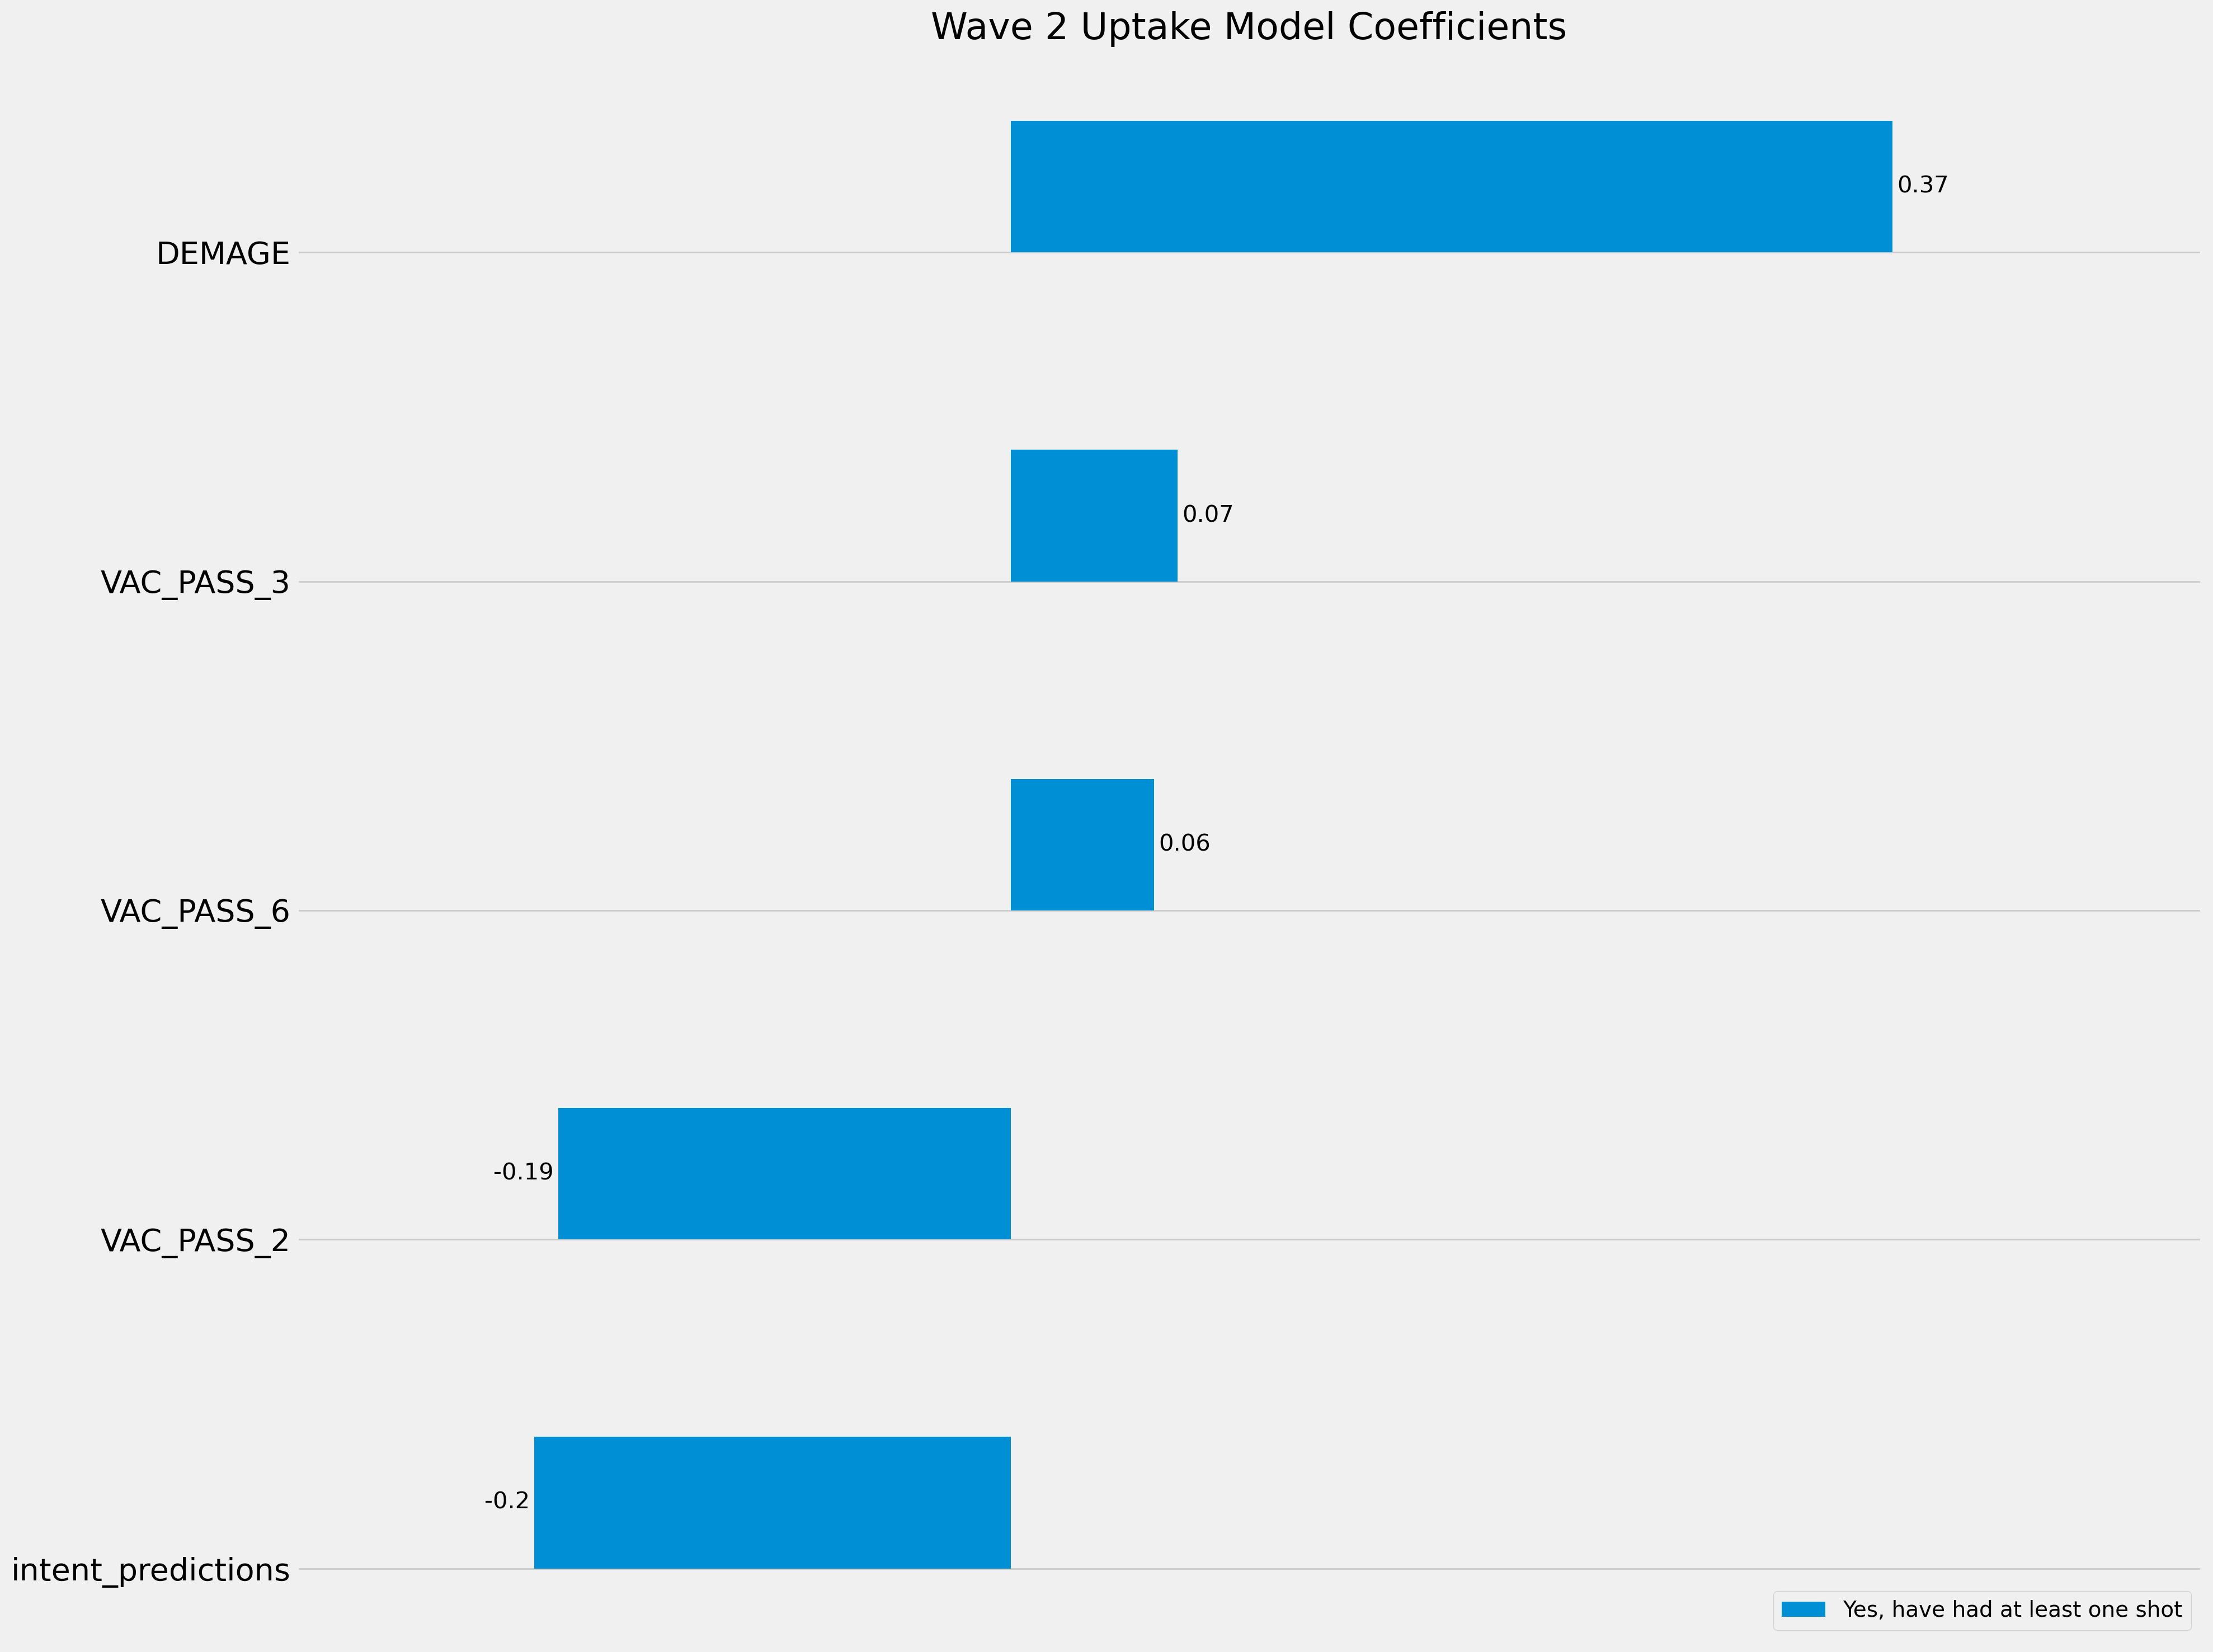

In [52]:
x = np.arange(len(labels))
width = 0.4


fig, ax = plt.subplots(figsize=(20, 15))
rects2 = ax.barh(x + width/2, value_1, width, label='Class 1')

ax.bar_label(rects2, padding=3, fontsize=15)
ax.set_yticks(x, labels, fontsize=20)
ax.set_xticks([])
ax.set_xlim(-0.3, 0.5)
ax.legend(labels=['Yes, have had at least one shot'], loc='lower right')
ax.set_title('Wave 2 Uptake Model Coefficients', fontsize=24)

fig.tight_layout()

plt.show()

In [53]:
# labels = list(Xtr_final.columns)
# value_1 = list(uptake_final.coef_[0])

# x = np.arange(len(labels))
# width = 0.4

# fig, ax = plt.subplots(figsize=(20, 30))
# rects1 = ax.barh(x - width/2, value_1, width, label='Class 1')

# ax.bar_label(rects1, padding=3)
# ax.set_yticks(x, labels, fontsize=10)
# ax.legend()

# fig.tight_layout()

# plt.show()

# Summary of findings

The above analysis aimed to provide a deeper understanding of the extent to which a limited set of demographic and attitudinal indicators could predict both willingness to take the COVID vaccine, and ultimately, actual uptake of the COVID vaccine among the UK public. The study aimed at informing efforts to design future interventions/campaigns aimed at encouraging increased vaccine uptake among those initially hesitant to take a vaccine.

The initial hypothesis questions were identified as:

-	Can we predict willingness to take the vaccine based on some demographic information, and some limited attitudinal info?
-	To what extent can these predictions be generalized to future data?
-	Can further information be added to the model to improve its predictions?
-	To what extent can these willingness predictions be used to predict actual uptake:
    - I.e. Do responses to the willingness questions appear to materially impact uptake predictions?


The analysis was run on two separate waves of data, one drawn from Autumn 2020 survey data, another drawn from a follow up survey (with different individuals) conducted in Spring 2021.

**Can we predict willingness to take the vaccine based on some demographic information, and some limited attitudinal info?**
Despite a significant imbalance in target classes, the initial wave 1 'willingness to take the COVID vaccine' model (fit on an unbalanced target sample) had some success in predicting the two 'extreme' classes - those who definitely will take the vaccine, or who definitely won't. Unsurprisingly, the model performs significantly less well on those who express uncertainty either way, however a logistic classification estimator, optimised on the training set, was able to improve the succesful identification of those who lean towards skepticism (albeit at a significant cost to model accuracy and precision). 

**To what extent can these predictions be generalized to future data?**
Unfortunately, the initial model generalises relatively poorly on wave 2 data, and even retraining the model on a wave 2 training data set using the same parameters and features fails to significantly improve results. It should be noted that the wider context changed significantly from Autumn 2020 to Spring 2021, therefore it is not surprising that a model that fails to take such factors into account does not perform well. 

**Can further information be added to the model to improve its predictions?**
Retraining the model using extra feature information only present in the wave 2 data set does improve the model's performance in maximising the recall of classes 1, 3 and 4. However, class 2 precision and recall is low. Furthermore, while recall is identified as the priority measure (over precision), the model does generally perform poorly on measures of precision.

An analysis of the features of importance does suggest that the impact of the changing wider context from wave to wave does impact on the model's prediction performance. While certain features are consistently important across both waves, such as high income levels indicating increased willingness to take the vaccine, and high disagreement with a number of attitudinal and awareness measures indicating higher hesitancy, age emerges as a large factor predicting an individual's willingness to take a vaccine in wave 2 compared to wave 1, while the impact of gender (men more likely to express willingness than women) seems to dissipate. This is presumably due to the age-based rollout of the vaccine programme (those older people still unvaccinated in wave 2 are likely 'holdouts' who self-select into the willingness sample (i.e. because they are 'unwilling' to take the vaccine), while fears about the potential complications of the vaccine among women in late 2020 had become less problematic as new vaccine types were produced. 

**To what extent can these willingness predictions be used to predict actual uptake**
Running an uptake model, similar to the willingness models created in previous stages, using the same feature matrix, plus the willingness model's predictions, generally performs well on the priority evaluation metrics of ROC AUC and recall. Nevertheless, precision for the minority 'negative' class remains low. The generated 'willingness' score does emerge as an important predictor variable, with those reporting to be less willing to take the vaccine also less likely to have followed through with the behaviour.

# Limitations/Caveats

As outlined in some detail above (and in data cleaning & EDA notebooks), we observe some limitations/there exists some caveats that should be borne in mind when interpreting the results of the modelling:

- The W2 sub samples are impacted by a changing context which skews certain variables:
    - The vaccine rollout was age-based, and wave 2 fieldwork took place halfway through the rollout (Spring 2021) therefore the 'intention' sample is skewed towards younger age groups, while the 'uptake' sample is skewed towards older age groups.
    - The W2 'intention' sample may be impacted by self-selection bias (especially among older age groups). That is, that older people who have not yet received the sample by W2 are more likely to be those who are unwilling to take the sample in the first place.
    - The W2 'intention' sample is significantly smaller than the other sample sizes, and this may impact on the robustness of the modelling results (as smaller sample sizes imply a less accurate model.
    
    
- Significant class imbalance impacts on all models' accuracy and prediction considerably. While recall (i.e. correctly classifying true values) for those unwilling to take/who have not taken the vaccine is prioritised, we observe very low precision scores for these classes also. This suggests that in order to correctly classify these classes, the models must misclassify other classes at a high rate. 

- While the uptake model found that willingness predictions did indeed predict uptake (i.e. self-reported willingness does indicate actual behaviour), willingness models' poor precision scores (see point above) suggest that willingness predictions feeding into the uptake model are inaccurate. Therefore findings around the impact of willingness predictions may also be unreliable. 

- The features included in the model are limited to demographics and some attitudinal variables. That age and willingness emerge as the most important predictors of uptake while other predictors are supressed suggests deeper underlying factors driving skepticism beyond demographics and the attitude variables featured in the survey. Further future exploration diving deeper into drivers of vaccine hesitancy (including drawing from other studies on the subject) may help to yield more informative findings.